# 0.0. IMPORTS

In [1]:
import os
import time
import math
import pickle
import datetime
import inflection 
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgbm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

#from bokeh.plotting import figure, show
#from bokeh.io import output_notebook

import matplotlib.colors     as mcolors
from IPython.core.display    import HTML
from scipy                   import stats
from IPython.display         import Image
from boruta                  import BorutaPy
from operator                import attrgetter
from sklearn.preprocessing   import LabelEncoder
from imblearn                import combine as c
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier, DMatrix
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model    import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score,StratifiedKFold
 
# model's metrics
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore');

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
def cross_validation ( x_training, kfold, model_name, model,  verbose=False ):
    
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+ 1) ):
        if verbose:
            print( '\nKfold Number: {}'.format( k ) )
            # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date )]
        
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
            
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m  = model.fit ( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1 ( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] ) 
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( {'Model Name': model_name,
                           'MAE CV': np.round( np.mean( mae_list), 2 ).astype (str ) + ' +/-' + np.round( np.std( mae_list ), 2 ).astype ( str ),
                          'MAPE CV': np.round( np.mean( mape_list), 2 ).astype (str ) + ' +/-' + np.round( np.std( mape_list ), 2 ).astype ( str ),
                         'RMSE CV': np.round( np.mean( rmse_list), 2 ).astype (str ) + ' +/-' + np.round( np.std( rmse_list ), 2 ).astype ( str ) }, index=[0] )

###

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()


    
def mean_percentage_error ( y, yhat ):
   return np.mean( ( y -yhat ) /  y )    

def mean_absolute_percentage_error ( y, yhat ):
   return np.mean( np.abs( ( y -yhat ) /  y ) )   


def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y , yhat )
    rmse = np.sqrt( mean_squared_error( y ,yhat) )
    
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0] )


def cramer_v( x, y):
    cm = pd.crosstab( a['state_holiday'], a['store_type'] ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )    
    
def plot_with_target(target_x, target_y, col, position_x, position_y, label_x, label_y):
    """
    Create some histplots with target feature.

    Returns:
        [Image]: [Histplots of all features with target]
    """


    plt.style.use('tableau-colorblind10')
    ax[position_x, position_y].hist(target_x[col], bins = 50, alpha = 0.5, label= label_x) 
    ax[position_x, position_y].hist(target_y[col], bins = 50, alpha = 0.7, label= label_y) 
    ax[position_x, position_y].legend()
    ax[position_x, position_y].set_title(col)

    return ax

def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)
    
    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

# Model's performance on test dataset function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat       = model.predict(x_test)
    yhat_proba = model.predict_proba(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df, yhat_proba

In [26]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# reading files
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=True)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=True)

# merging files
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on= 'Store')

# 1.0. STEP 1 - DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
183337,478,2,2015-02-17,7592,738,1,1,0,0,d,c,1940.0,3.0,2012.0,0,NaN,NaN,NaN


## 1.5. Fillout NA

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] =  df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=True)
                                
# competition_open_since_year        
df1['competition_open_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=True)
                                                                                          
# promo2_since_week
df1['promo2_since_week'] =  df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=True)

# promo2_since_year  
df1['promo2_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=True)

In [12]:
# promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',9: 'Sep' ,10: 'Oct', 11: 'Nov',  12: 'Dec'}


df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
229599,1025,3,2015-01-07,7598,882,1,1,0,1,a,a,720.0,11.0,2009.0,0,2.0,2015.0,0,Jan,0


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

## 1.7. Descriptive Statistical

In [17]:
num_att = df1.select_dtypes( include=['int64', 'float64'] )
cat_att = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [18]:
cat_att.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

## 1.7.1. Numerical Attributes

In [19]:
cat_att.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
50411,0,a,a,0,Jun


In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean)  ).T
ct2 = pd.DataFrame( num_att.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_att.apply ( np.std )).T
d2 = pd.DataFrame( num_att.apply ( min )).T
d3 = pd.DataFrame( num_att.apply ( max )).T
d4 = pd.DataFrame( num_att.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_att.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_att.apply ( lambda x: x.kurtosis() ) ).T
 
    
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

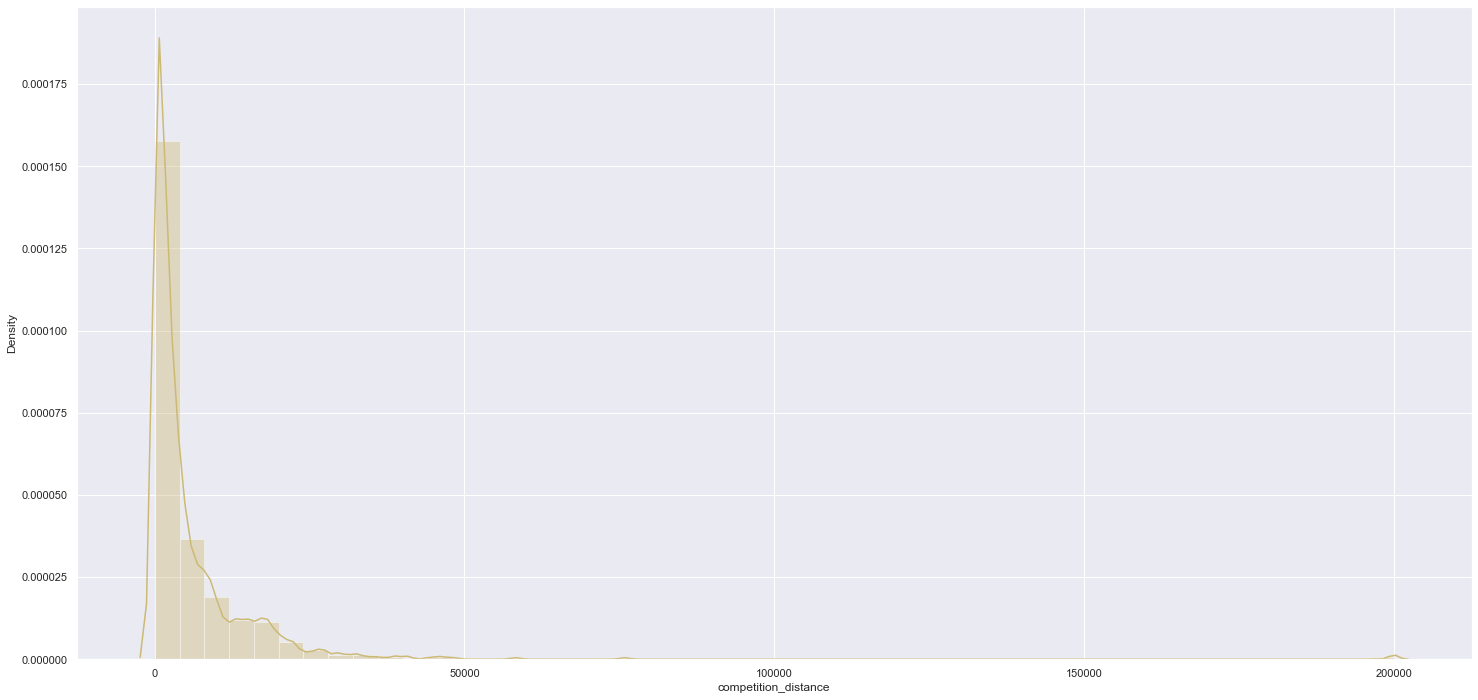

In [21]:
sns.distplot(df1['competition_distance'],color='y')

## 1.7.2. Categorical Attributes

In [22]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:>

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

<AxesSubplot:>

<AxesSubplot:xlabel='store_type', ylabel='sales'>

<AxesSubplot:>

<AxesSubplot:xlabel='assortment', ylabel='sales'>

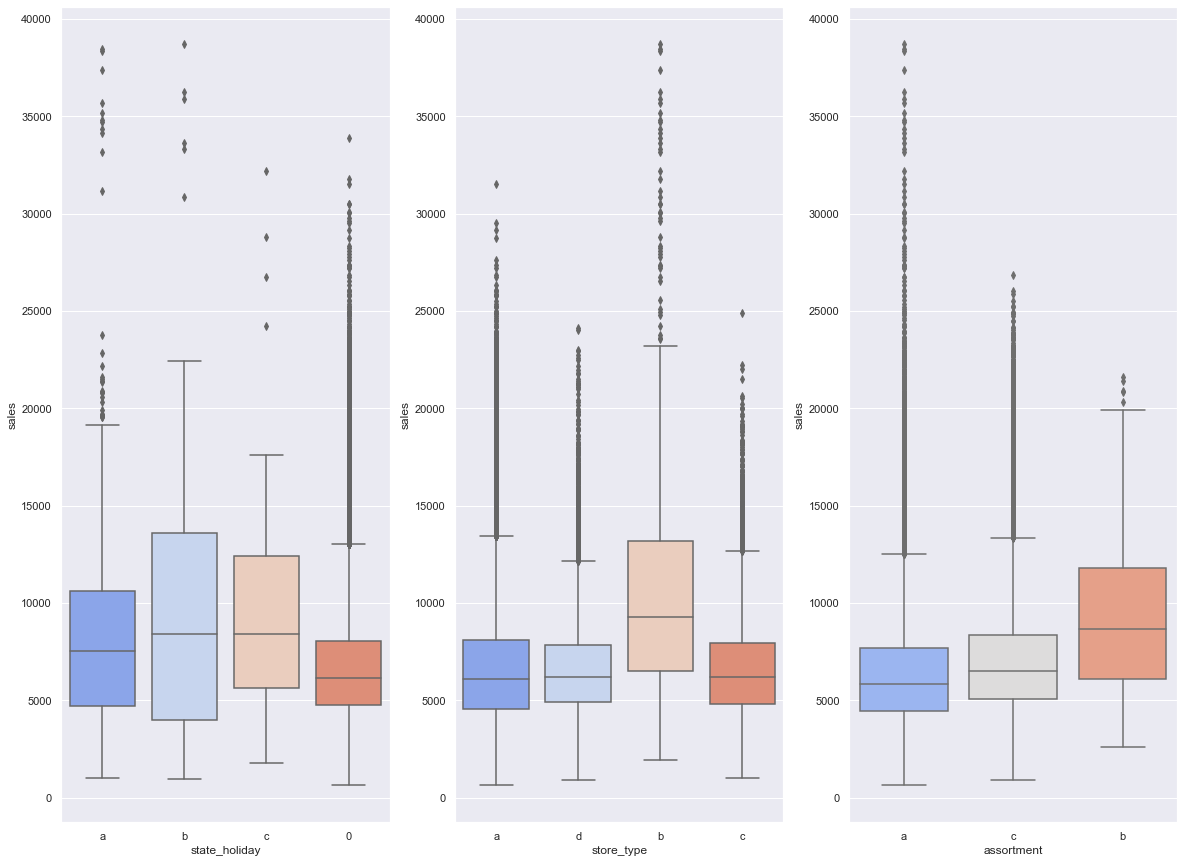

In [23]:
fig, aux1 = plt.subplots(figsize=(20,15))
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux, palette='coolwarm')

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux, palette='coolwarm' )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux, palette='coolwarm' )

# 2.0. STEP 2 - FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1. Hypothesis Mindmap

## 2.2. Creating Hypothesis

### 2.1.1 -  Store Hypothesis

**1.** Stores with more employers should sell more.

**2.** Stores with higher stock should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with more options should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for longer should sell less. 


### 2.1.2 -  Products Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores that expose more their products should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores that have agressive discounts should sell more.

**5.** Stores that have promotions for longer should sell more.

**6.** Stores with higher number of active promo days sell more.

**7.** Stores with more consecutive promo days sell more.

### 2.1.3 -   Temporal Hypothesis

**1.** Stores that open on Christmas should sell more. 

**2.** Stores should sell more when around for longer.

**3.** Stores should sell more on the second semester.

**4.** Stores should sell more after the 10th.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays. 

## 2.3. Final Hypothesis

## 2.4. Feature Engineering

**1.**  Stores with more options should sell more.

**2.**  Stores with closer competitors should sell less.

**3.**  Stores with competitors for longer should sell more.

**4.**  Stores that have promotions for longer should sell more.

**5.**  Stores with higher number of active promo days sell more.

**6.**  Stores with more consecutive promo days sell more.

**7.**  Stores with more consecutive promo days sell more.

**8.**  Stores that open on Christmas should sell more.

**9.**  Stores should sell more when around for longer.

**10.** Stores should sell more on the second semester.

**11.** Stores should sell more after the 10th.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since

df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 3 - VARIABLE FILTERING

In [27]:
df3 = df2.copy()

## 3.1. Row FIltering

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column selection

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. STEP 4 - EXPLORATORY ANALYSIS

In [31]:
df4 = df3.copy()

## 4.1. Univariable Anaysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales'>

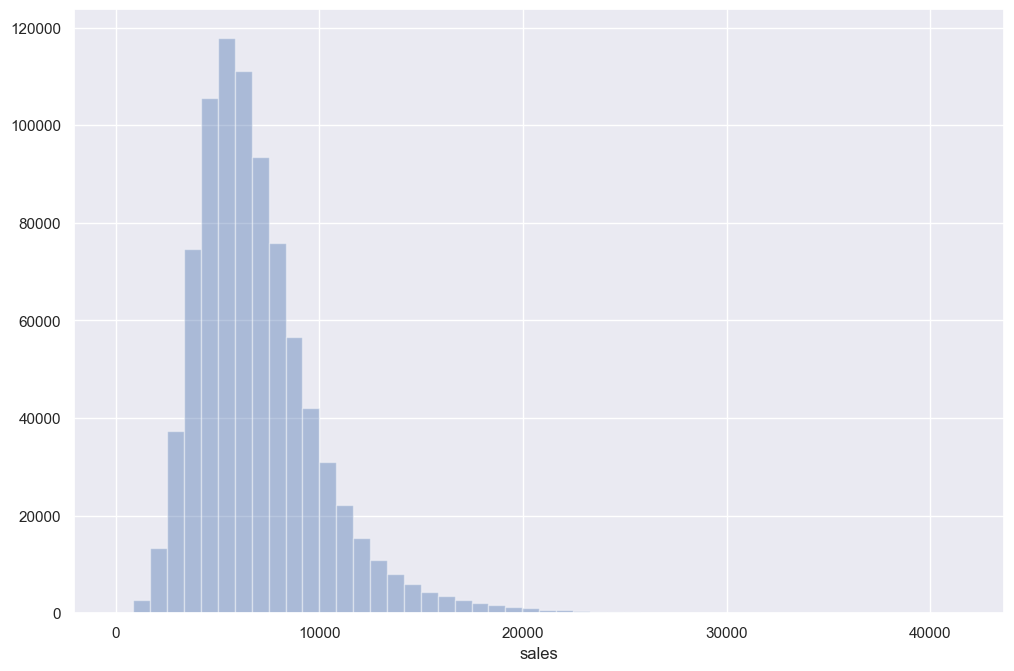

In [32]:
fig, ax = plt.subplots(figsize=(12,8),dpi=100);
sns.distplot(df4['sales'] , kde=False)

### 4.1.2. Numerical Variable

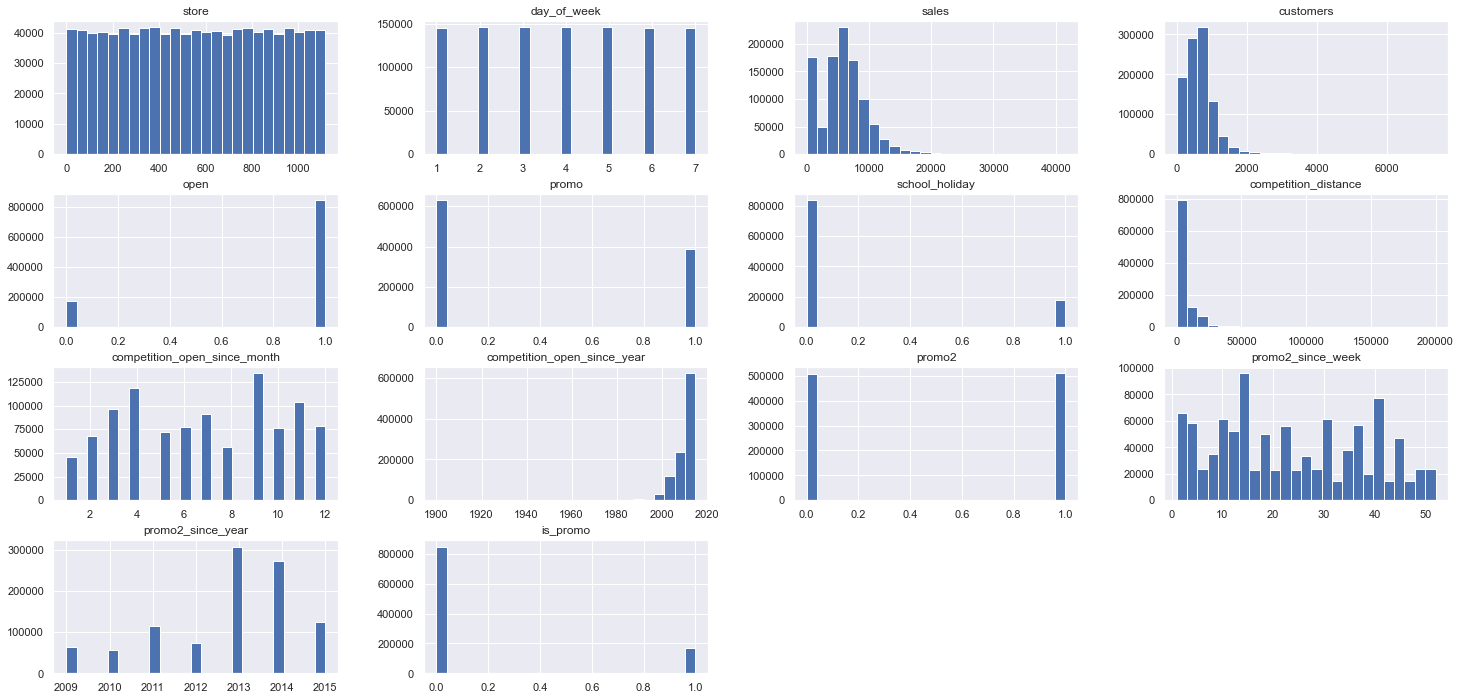

In [33]:
 
num_att.hist( bins=25 );

### 4.1.3. Categorical Variable

<AxesSubplot:>

<AxesSubplot:xlabel='state_holiday', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='store_type', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='assortment', ylabel='count'>

<AxesSubplot:>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:xlabel='sales', ylabel='Density'>

<AxesSubplot:xlabel='sales', ylabel='Density'>

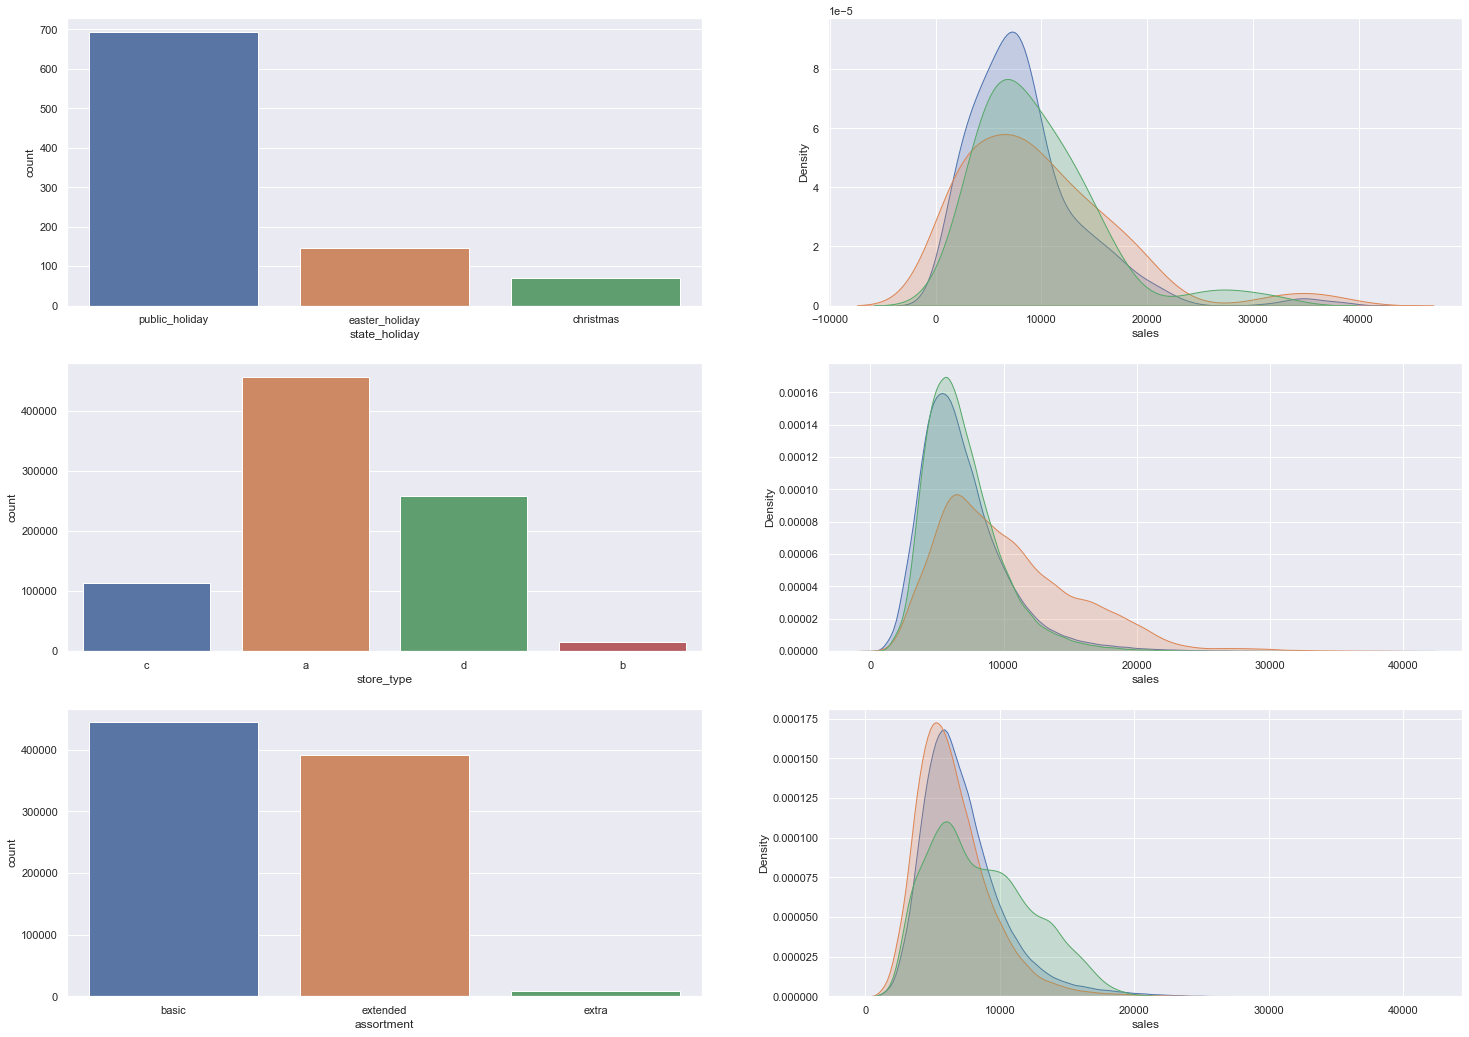

In [34]:
sns.set_theme()                                           
plt.rcParams['figure.figsize'] = [25, 18]                         
# state_holiday
plt.subplot(3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True,)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True,)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas_holiday',shade=True,)

# store_type
plt.subplot(3, 2, 3 )

sns.countplot( df4['store_type'] )

plt.subplot(3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True,)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True,)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True,)

# assortment
plt.subplot(3, 2, 5 )

sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True,)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True,)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True,)

## 4.2. Bivariable Anaysis

### H1. Stores with more options should sell more.
**FALSE.** Stores with more options sell less.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

<AxesSubplot:xlabel='year_week'>

<AxesSubplot:xlabel='year_week'>

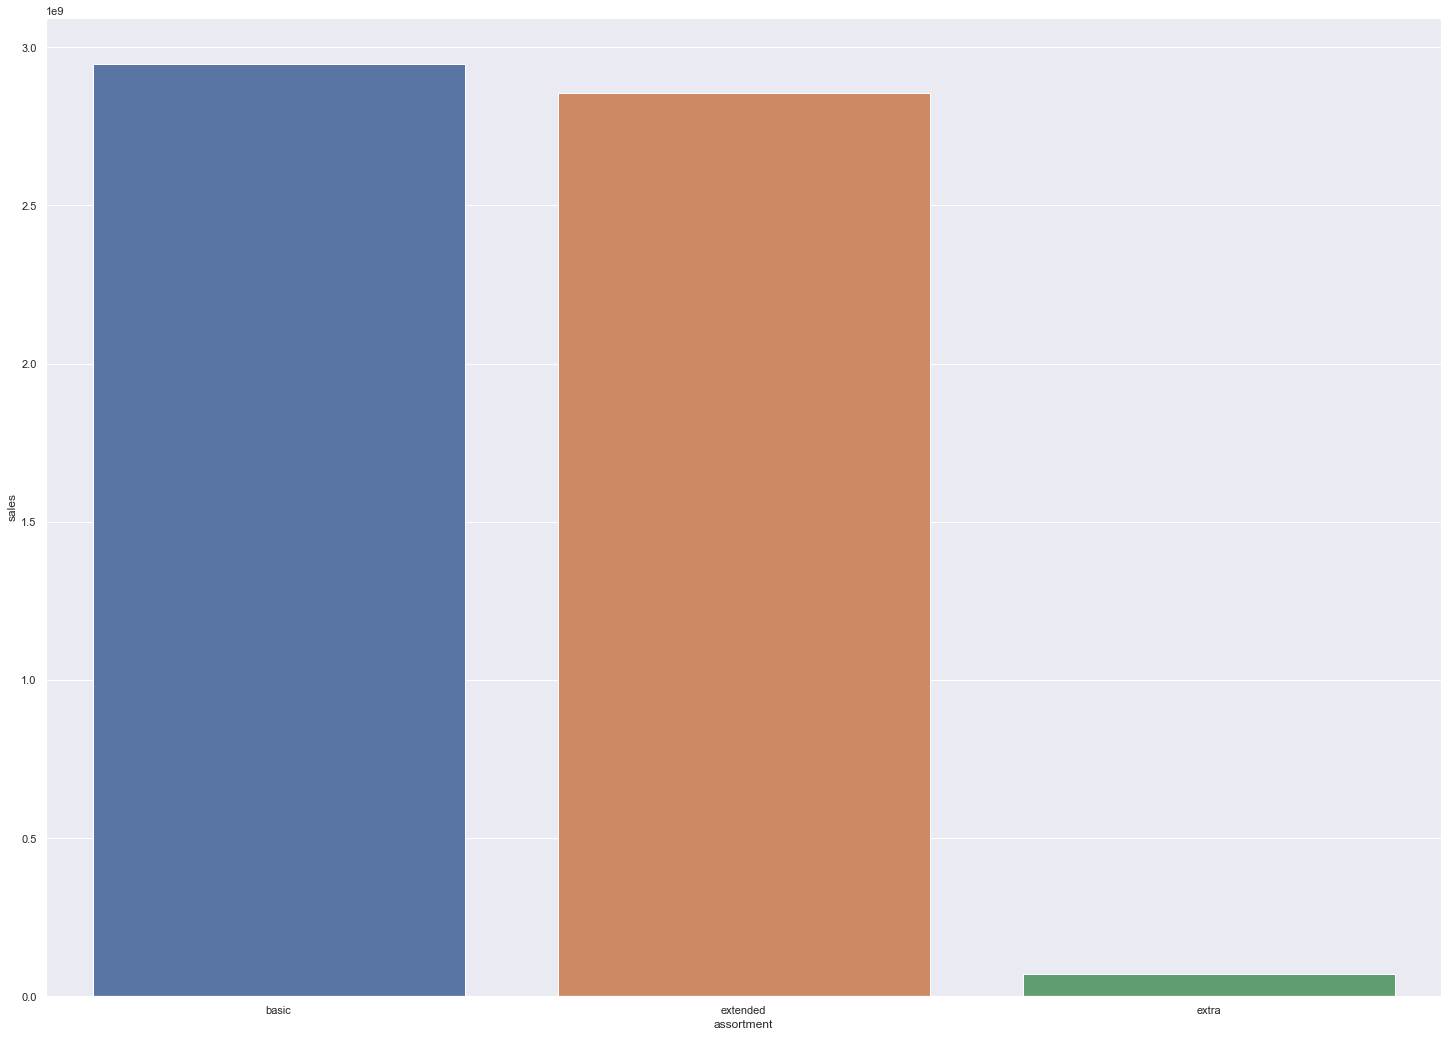

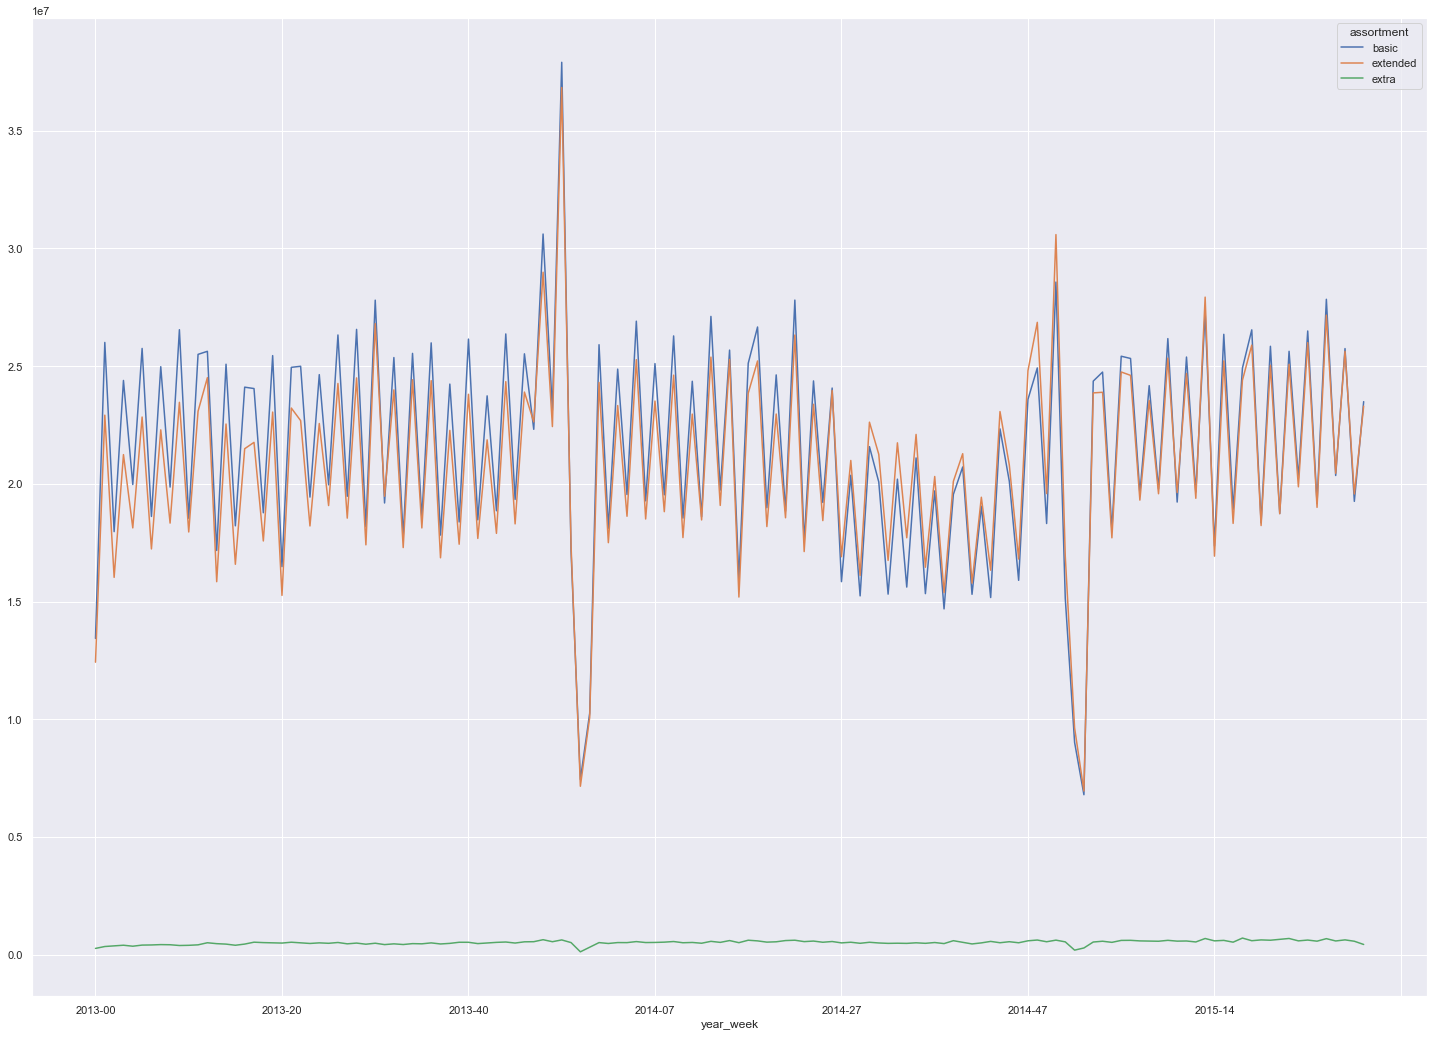

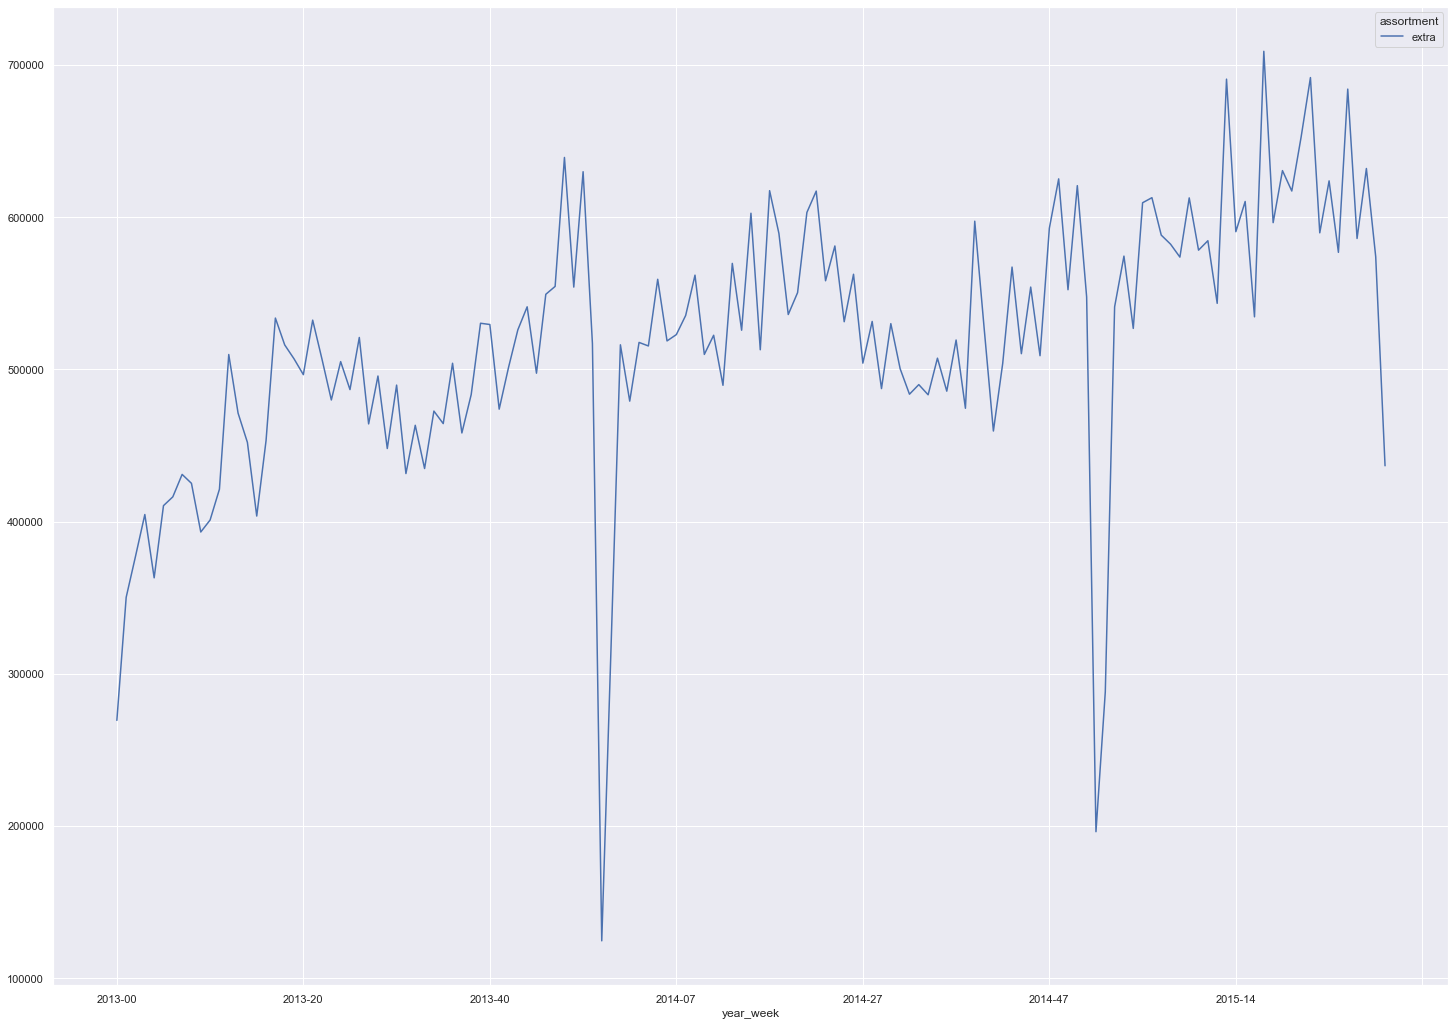

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

### H2. Stores with closer competitors should sell less.
**FALSE**. Stores with closer competitors sell more.

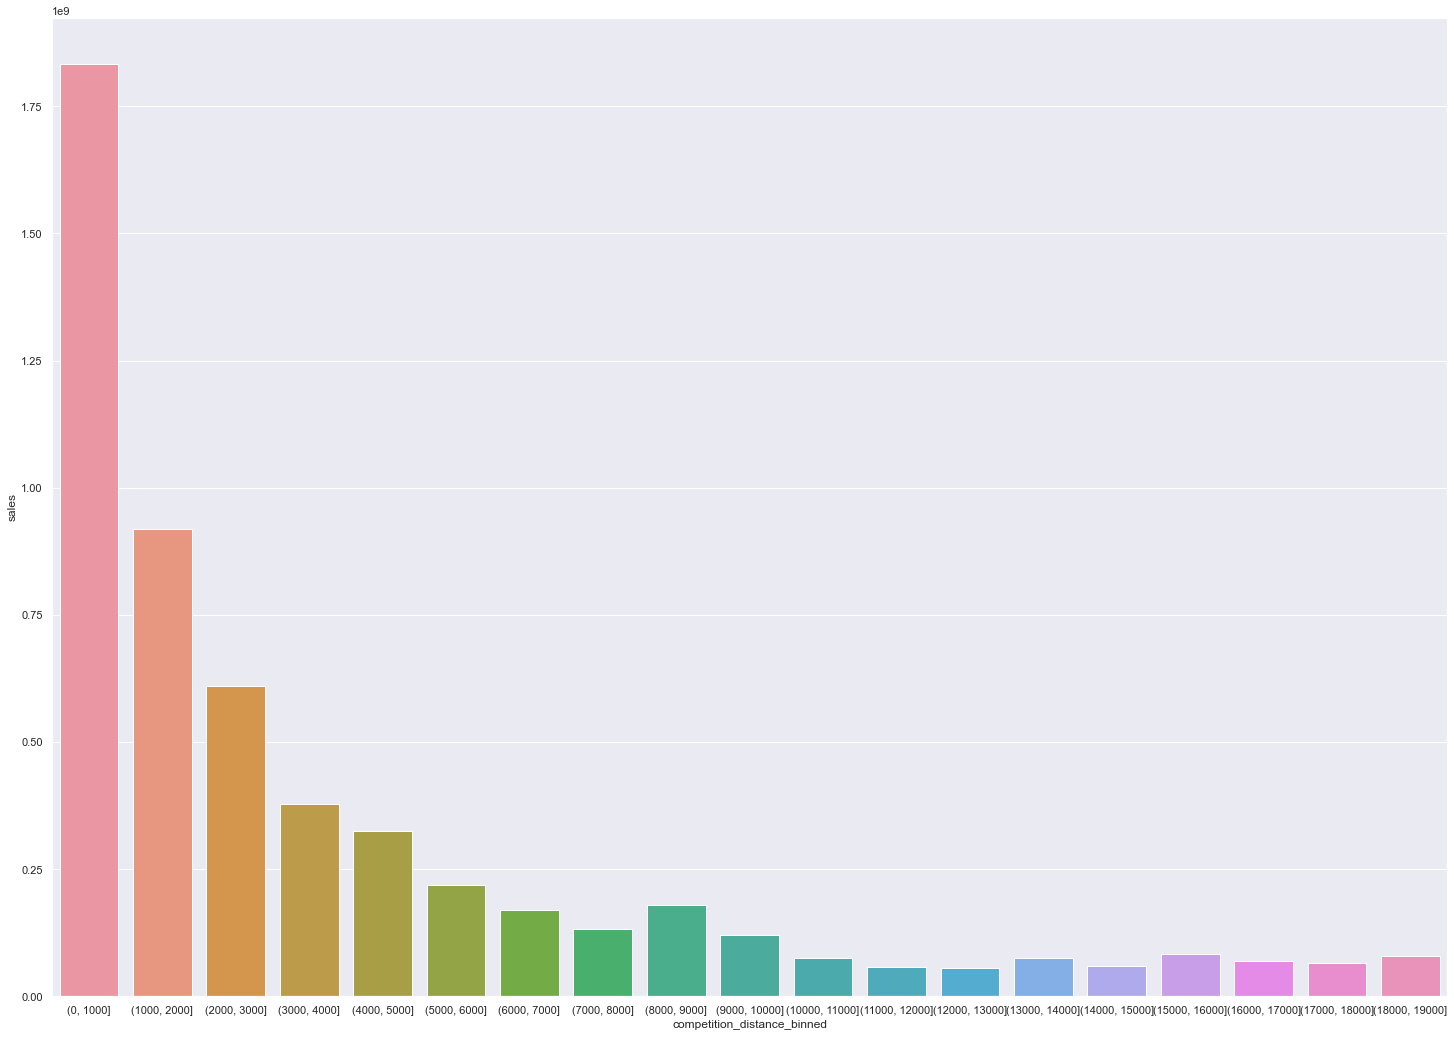

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange( 0,  20000, 1000) )

aux1['competition_distance_binned']=  pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot( x= 'competition_distance_binned', y= 'sales', data=aux2);
 

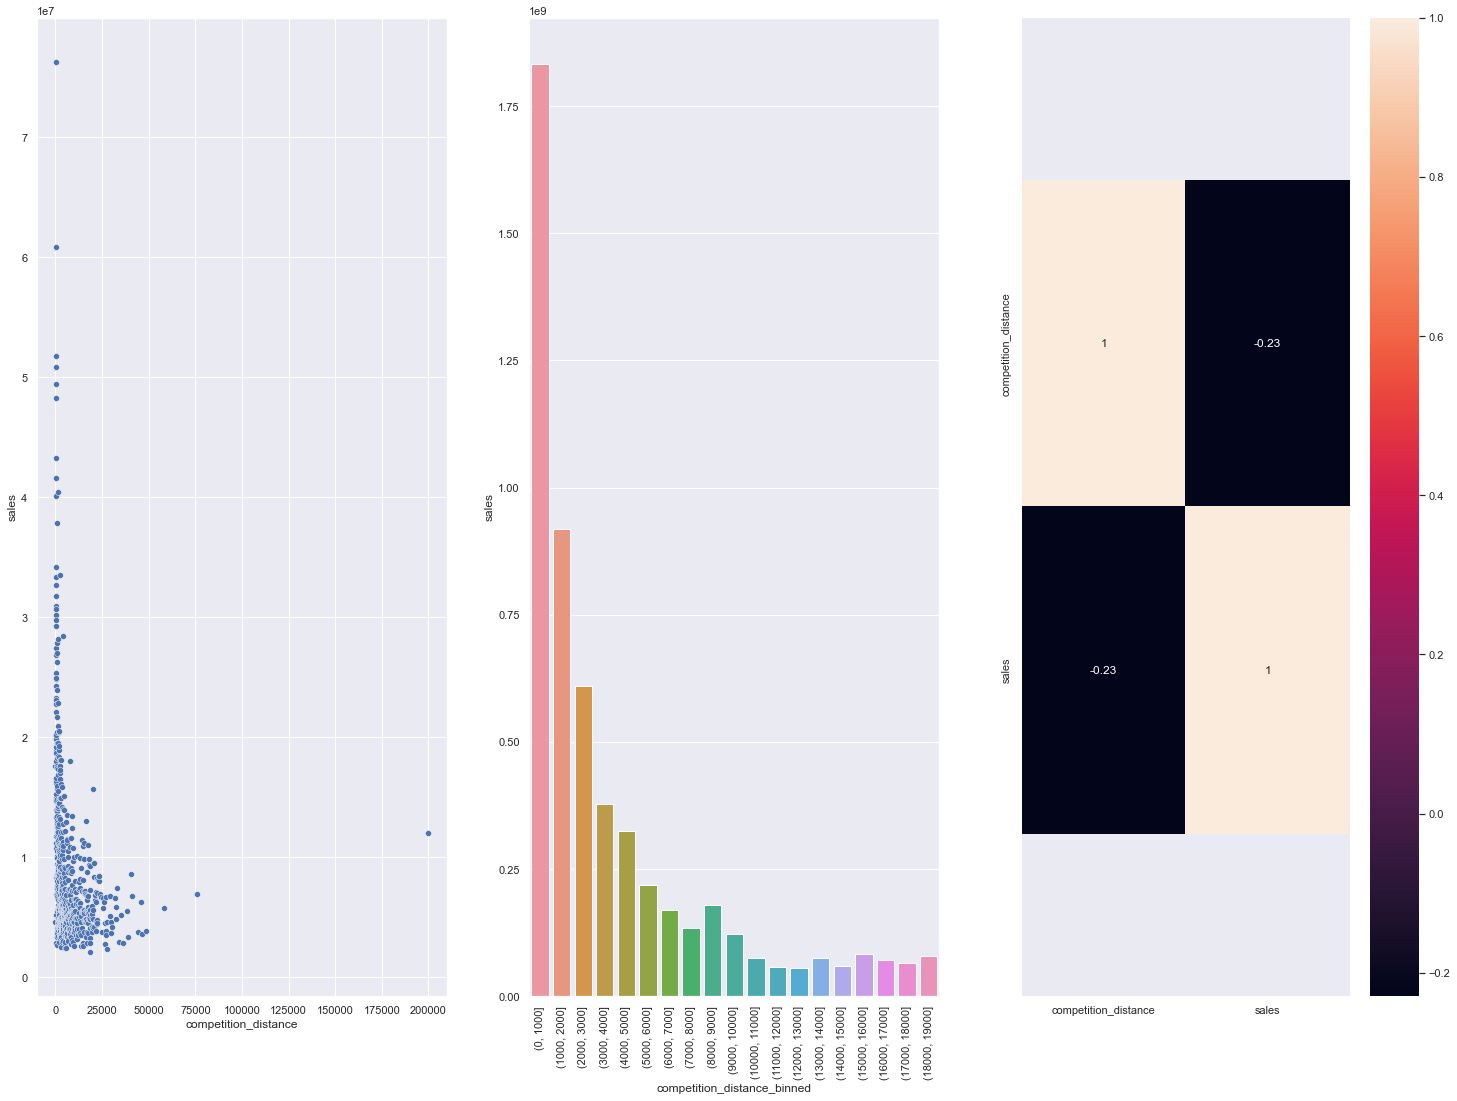

In [37]:
# measuring the corelation between the distance and the volume of sales
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1 )
sns.scatterplot(x='competition_distance',y='sales', data=aux1 );

plt.subplot(1, 3, 2 )
bins = list( np.arange( 0,  20000, 1000) )
aux1['competition_distance_binned']=  pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x= 'competition_distance_binned', y= 'sales', data=aux2);

# rotate axis for better visualization
plt.xticks( rotation= 90);


plt.subplot( 1, 3, 3)
x= sns.heatmap( aux1.corr( method='pearson' ), annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H3.  Stores that had competitors around for longer should sell more.
**FALSE**. Stores that had competitors around for longer sell less.

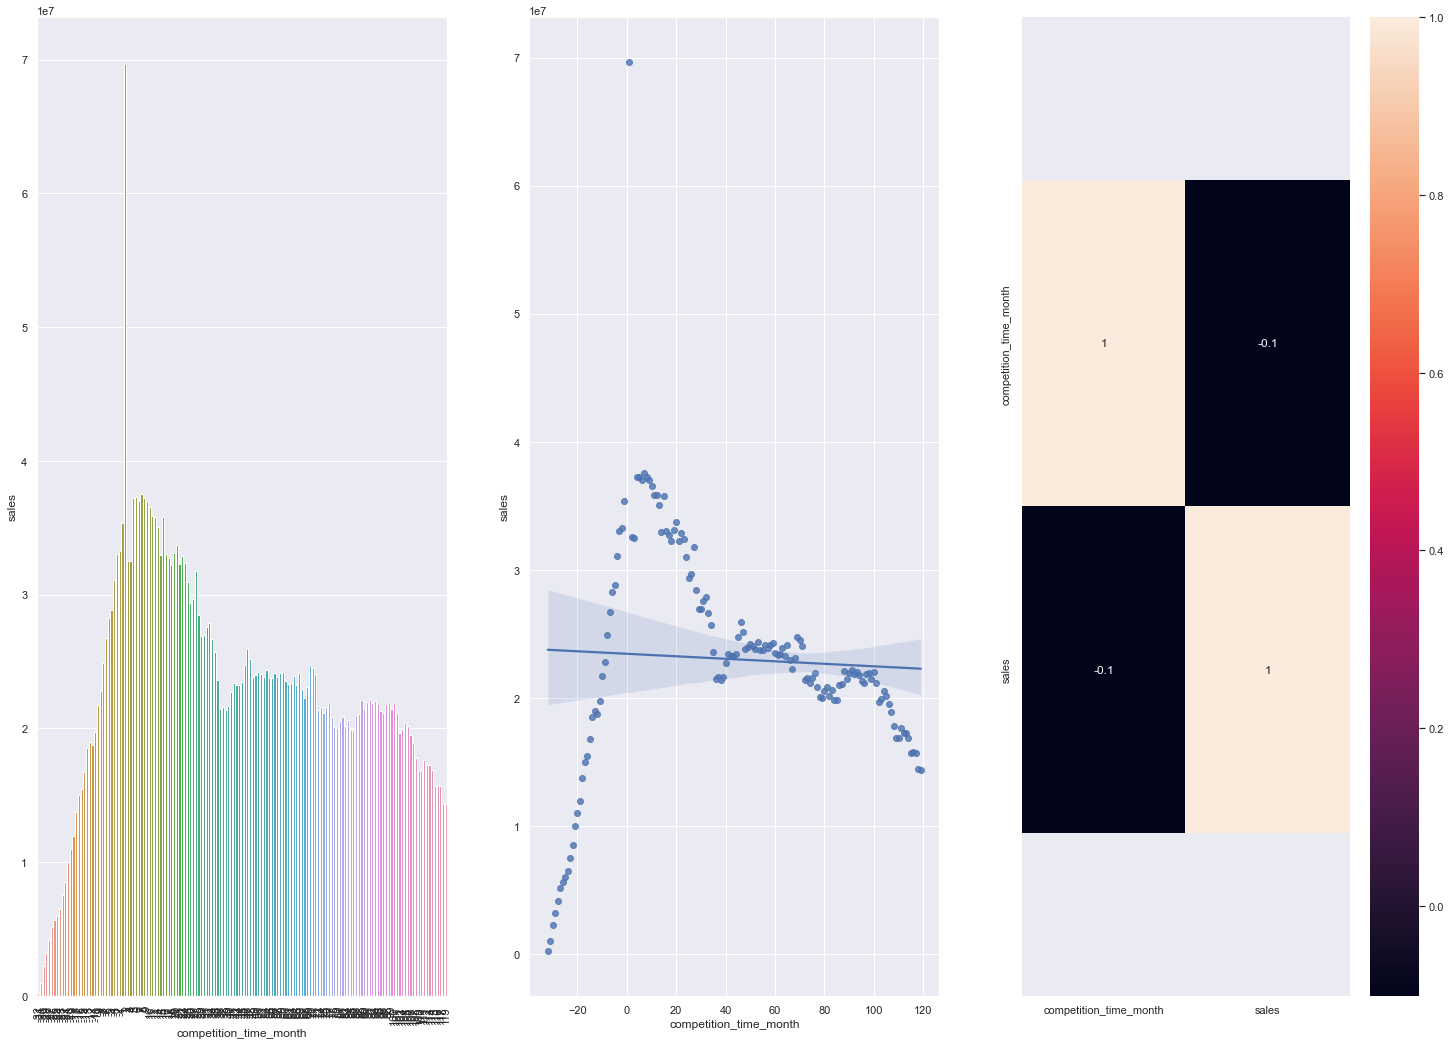

In [38]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month']  != 0)]
sns.barplot(x= 'competition_time_month',y='sales',data=aux2);
plt.xticks( rotation=90);

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot( 1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H4. Stores with higher number of active promo days sell more.

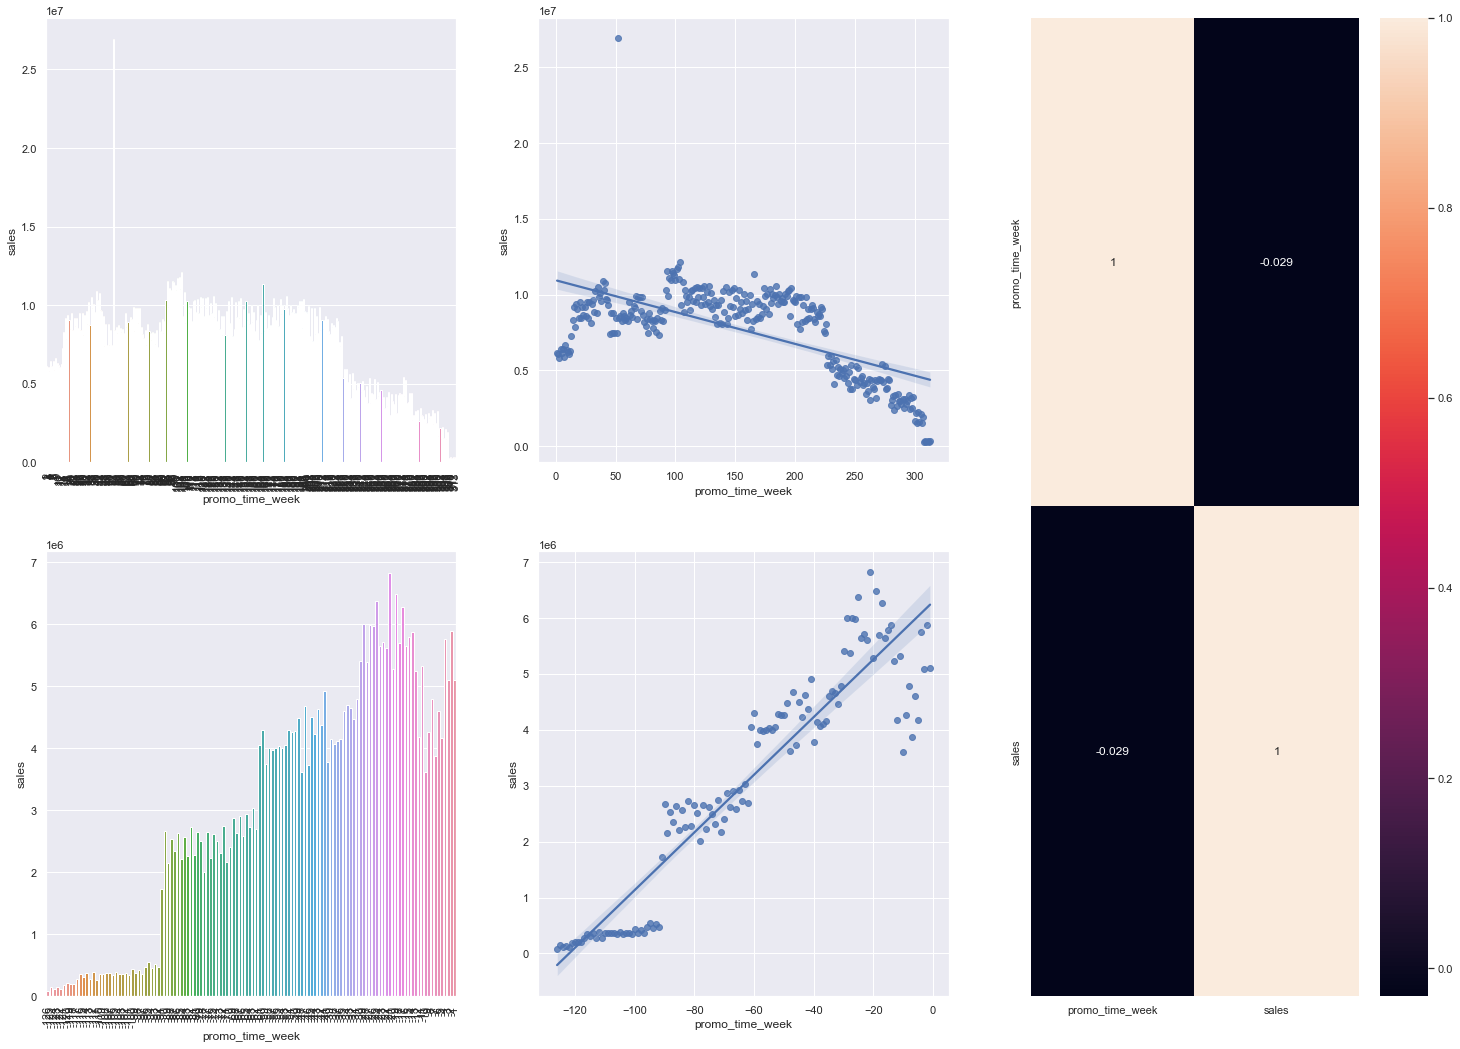

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H5. Stores with more consecutive promo days sell more. 
**Standby**

### H6. Stores with more consecutive promo days sell more.

In [40]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


### H6. Stores with more consecutive promo days sell more.

### H7. Stores that open on Christmas should sell more.

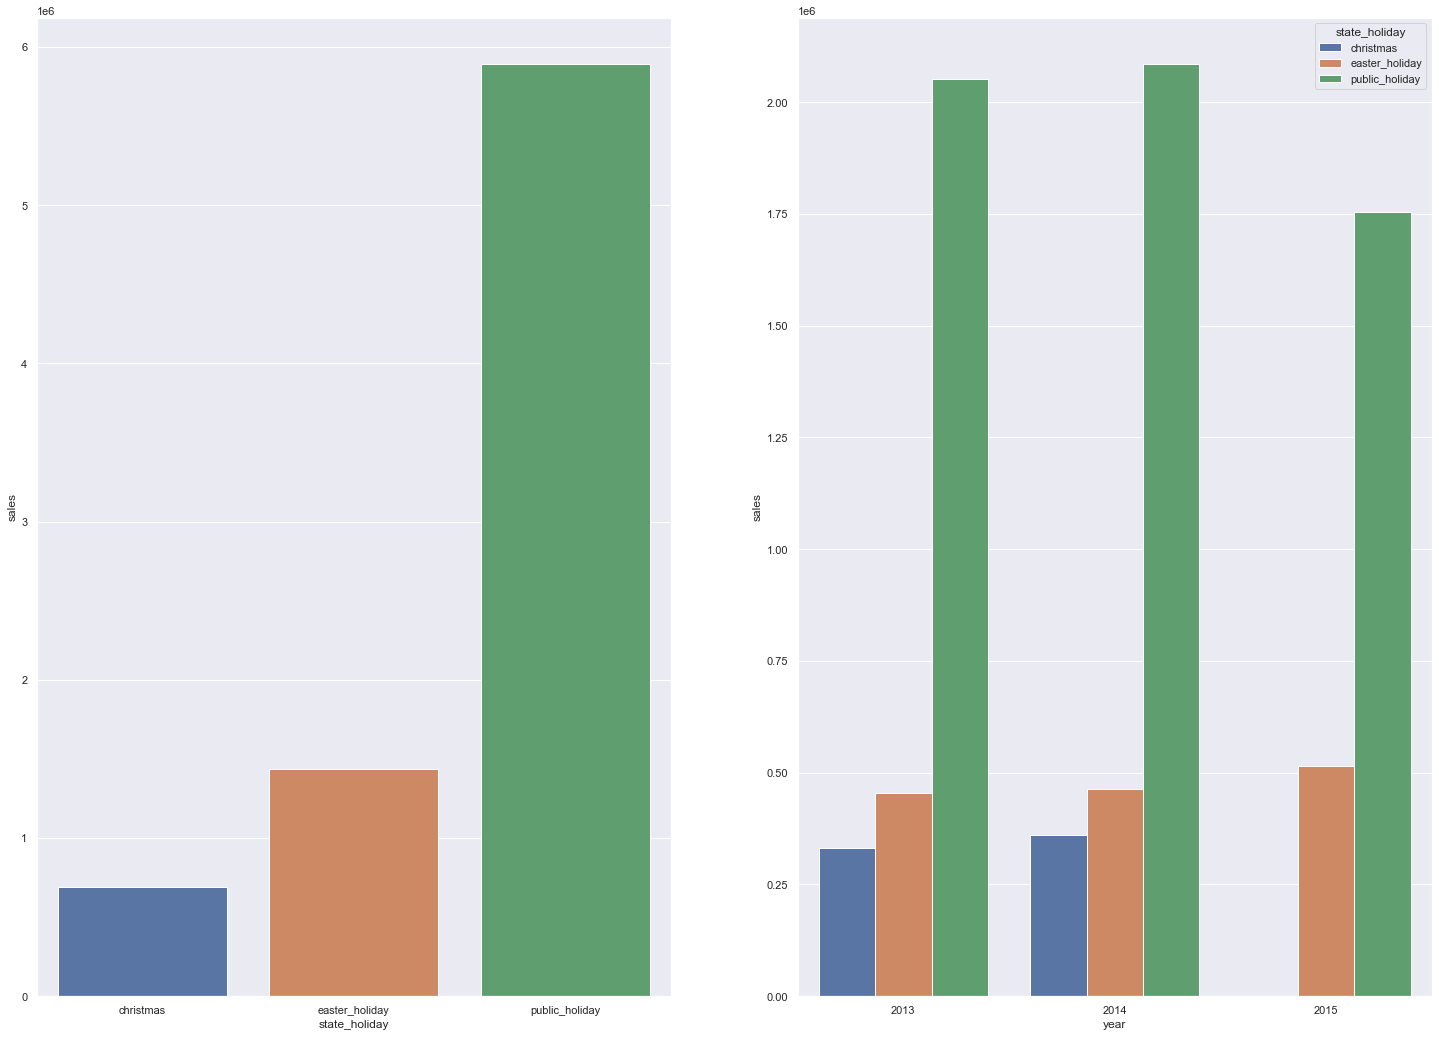

In [41]:
aux= df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales',hue='state_holiday', data=aux2);

### H8. Stores should sell more throughout the years.
**False** Stores sell less throughout the years.

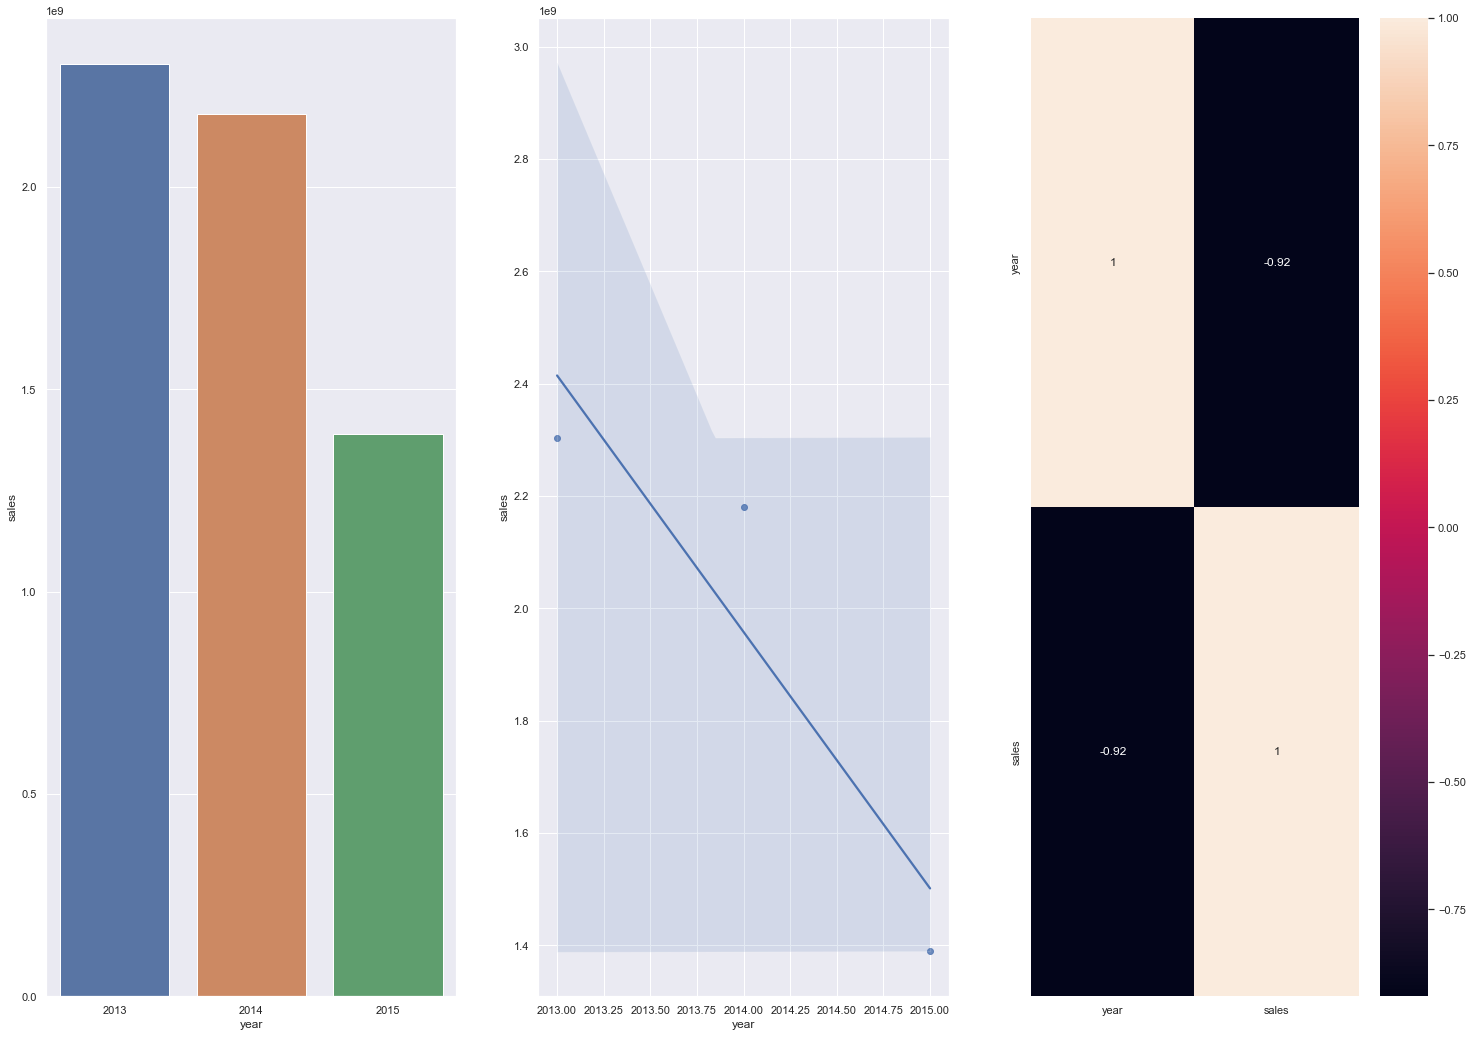

In [42]:
aux1 = df4[['year', 'sales']].groupby( 'year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

### H9. Stores should sell more on the second semester.
**False** Stores sell less in the second semester. 

### H10. Stores should sell more on the second semester.

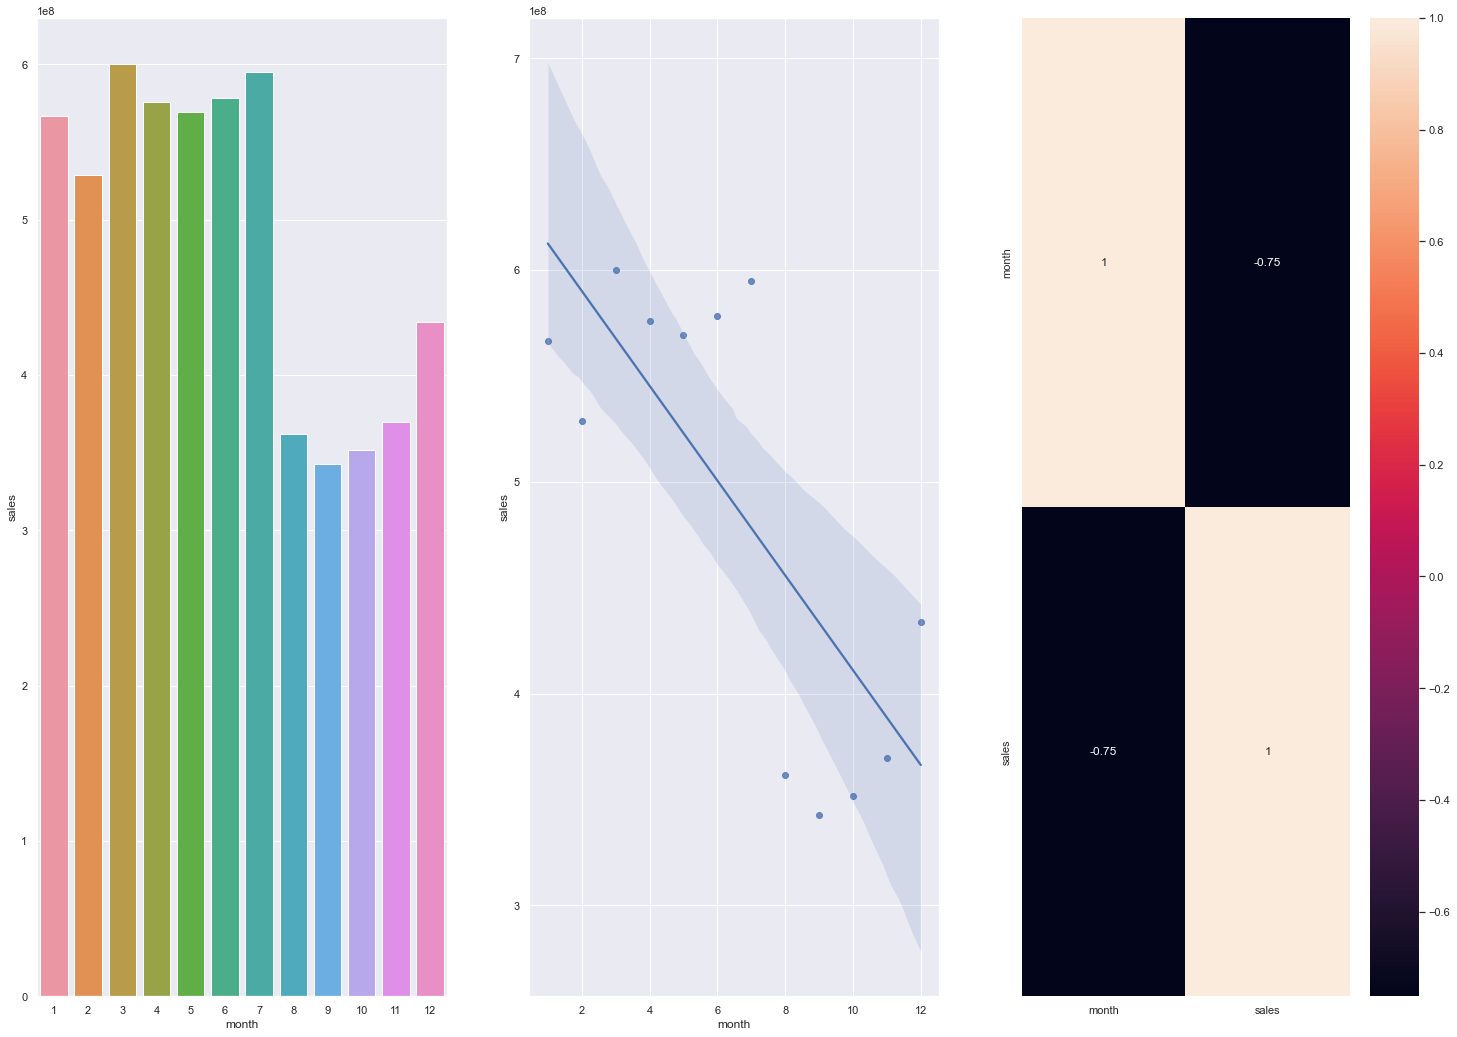

In [43]:
aux1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

### H11. Stores should sell more after the 10th.
**True**   

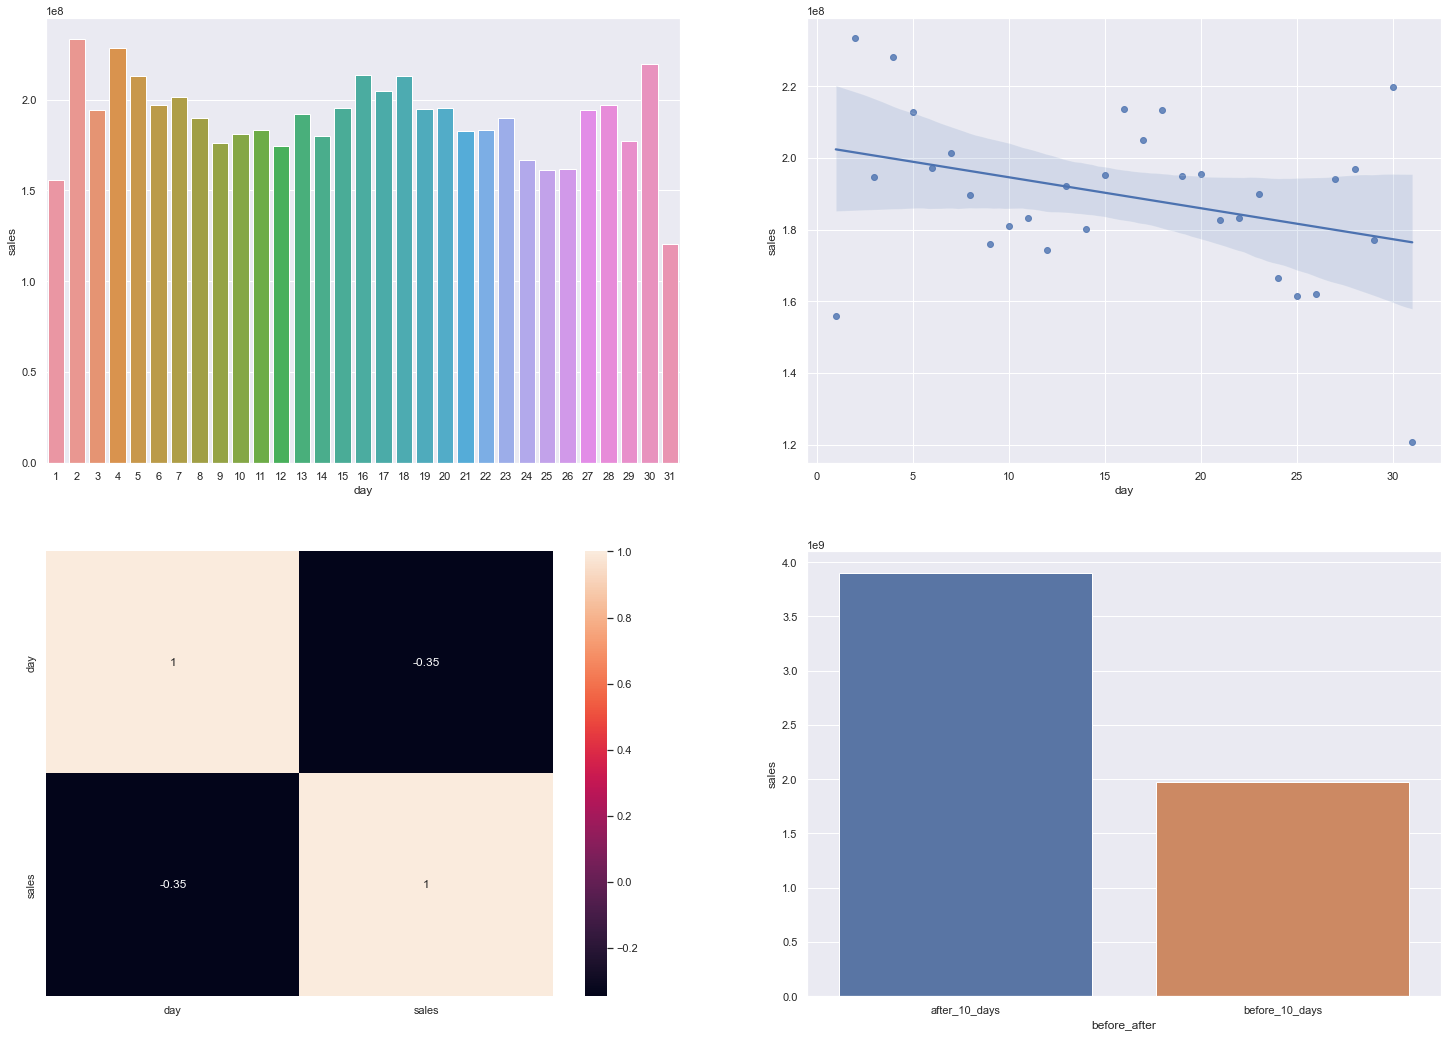

In [44]:
aux1 = df4[['day', 'sales']].groupby( 'day').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2);

### H12. Stores should sell less on weekends.
**True**

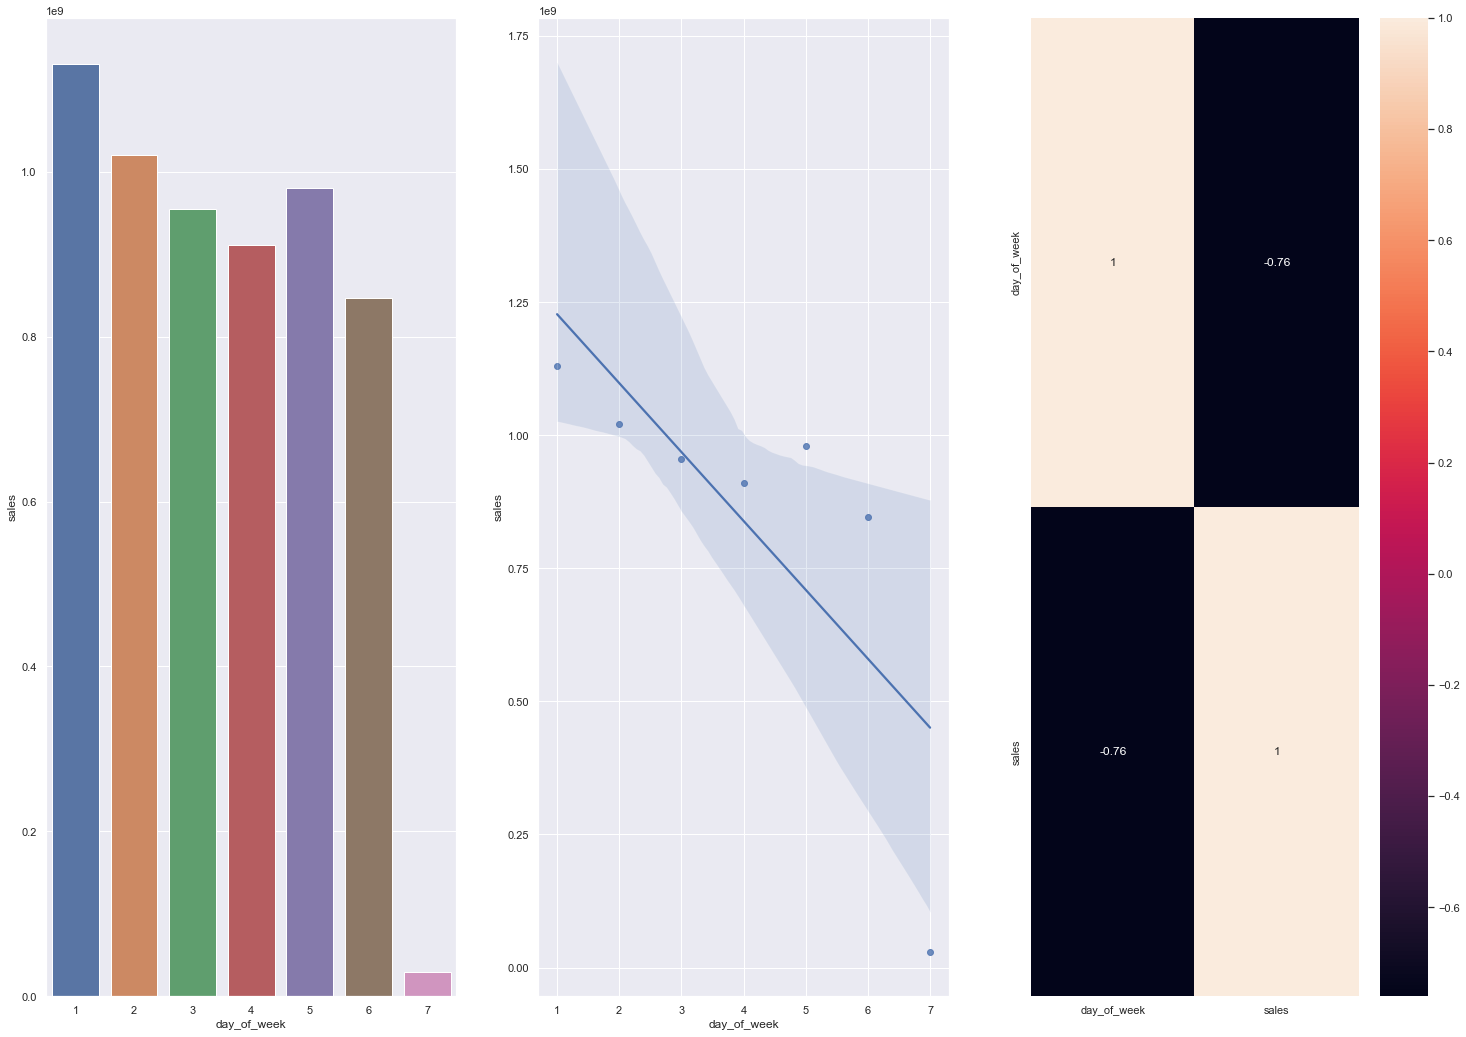

In [45]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method= 'pearson'), annot=True );

### H13.Stores should sell less during school holidays.

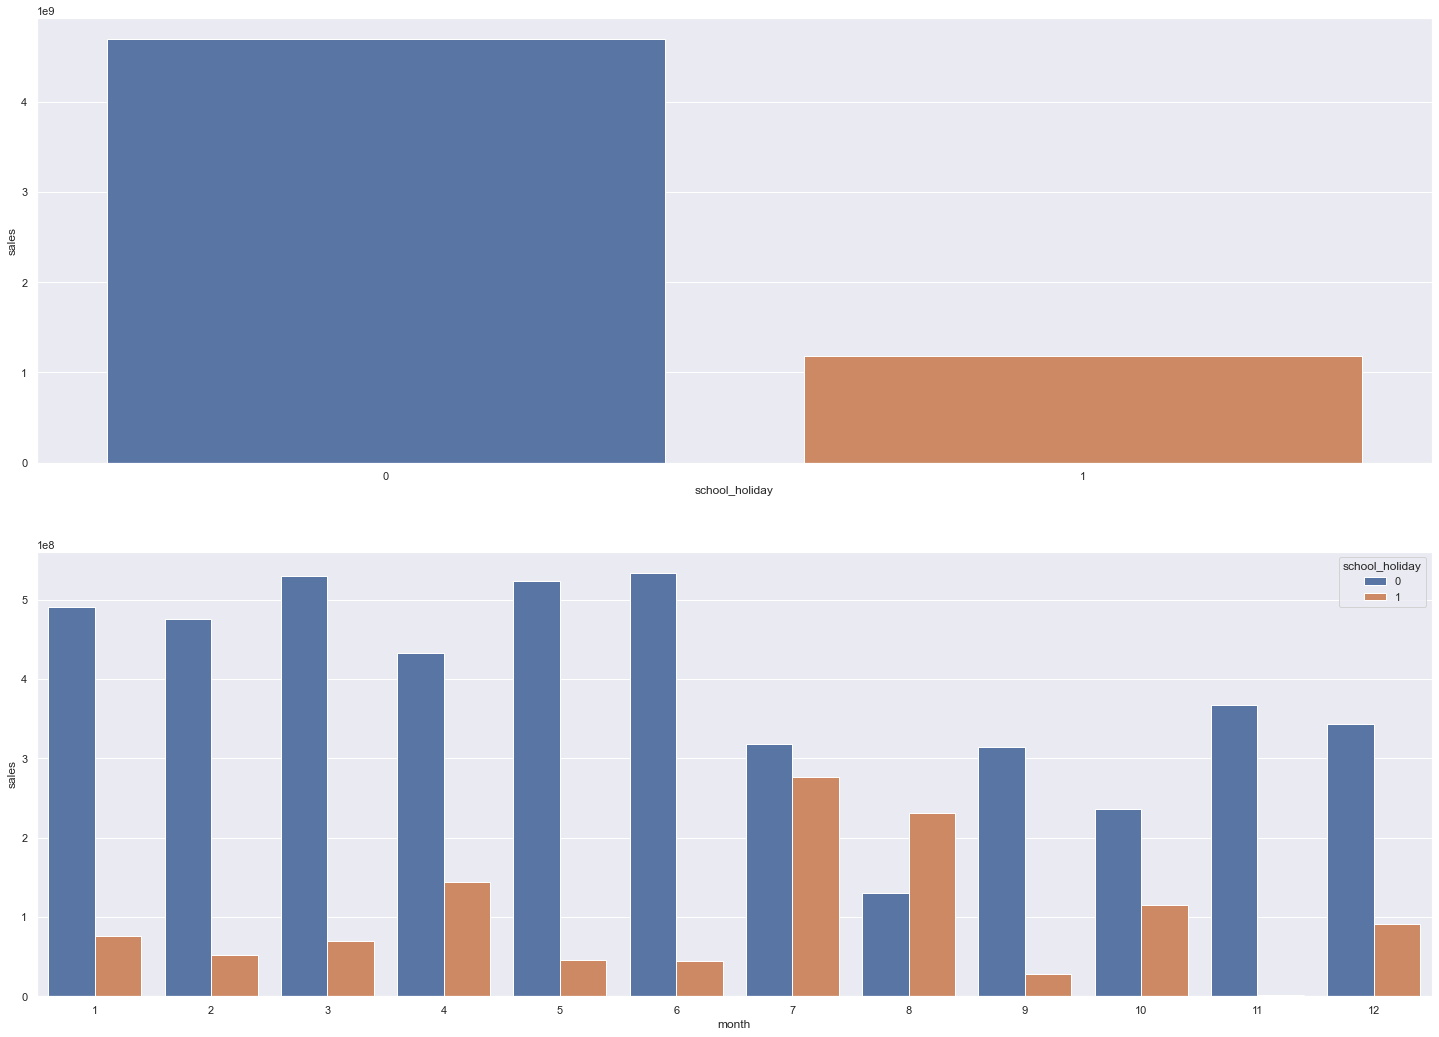

In [46]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday').sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month','school_holiday']).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday',data=aux2);

### 4.2.1. Hipothesis summary

In [47]:
from tabulate import tabulate

In [48]:
tab = [['Hipothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Low'],
       ['H8', 'False', 'Medium'],
       ['H9', 'False', 'High'],
       ['H10', 'False', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'High'],
       ['H13', 'True', 'Low'],
      ]
print( tabulate( tab, headers='firstrow') )

Hipothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Low
H8            False         Medium
H9            False         High
H10           False         High
H11           True          High
H12           True          High
H13           True          Low


## 4.3. Multivariable Anaysis

### 4.3.1 Numerical Attributes

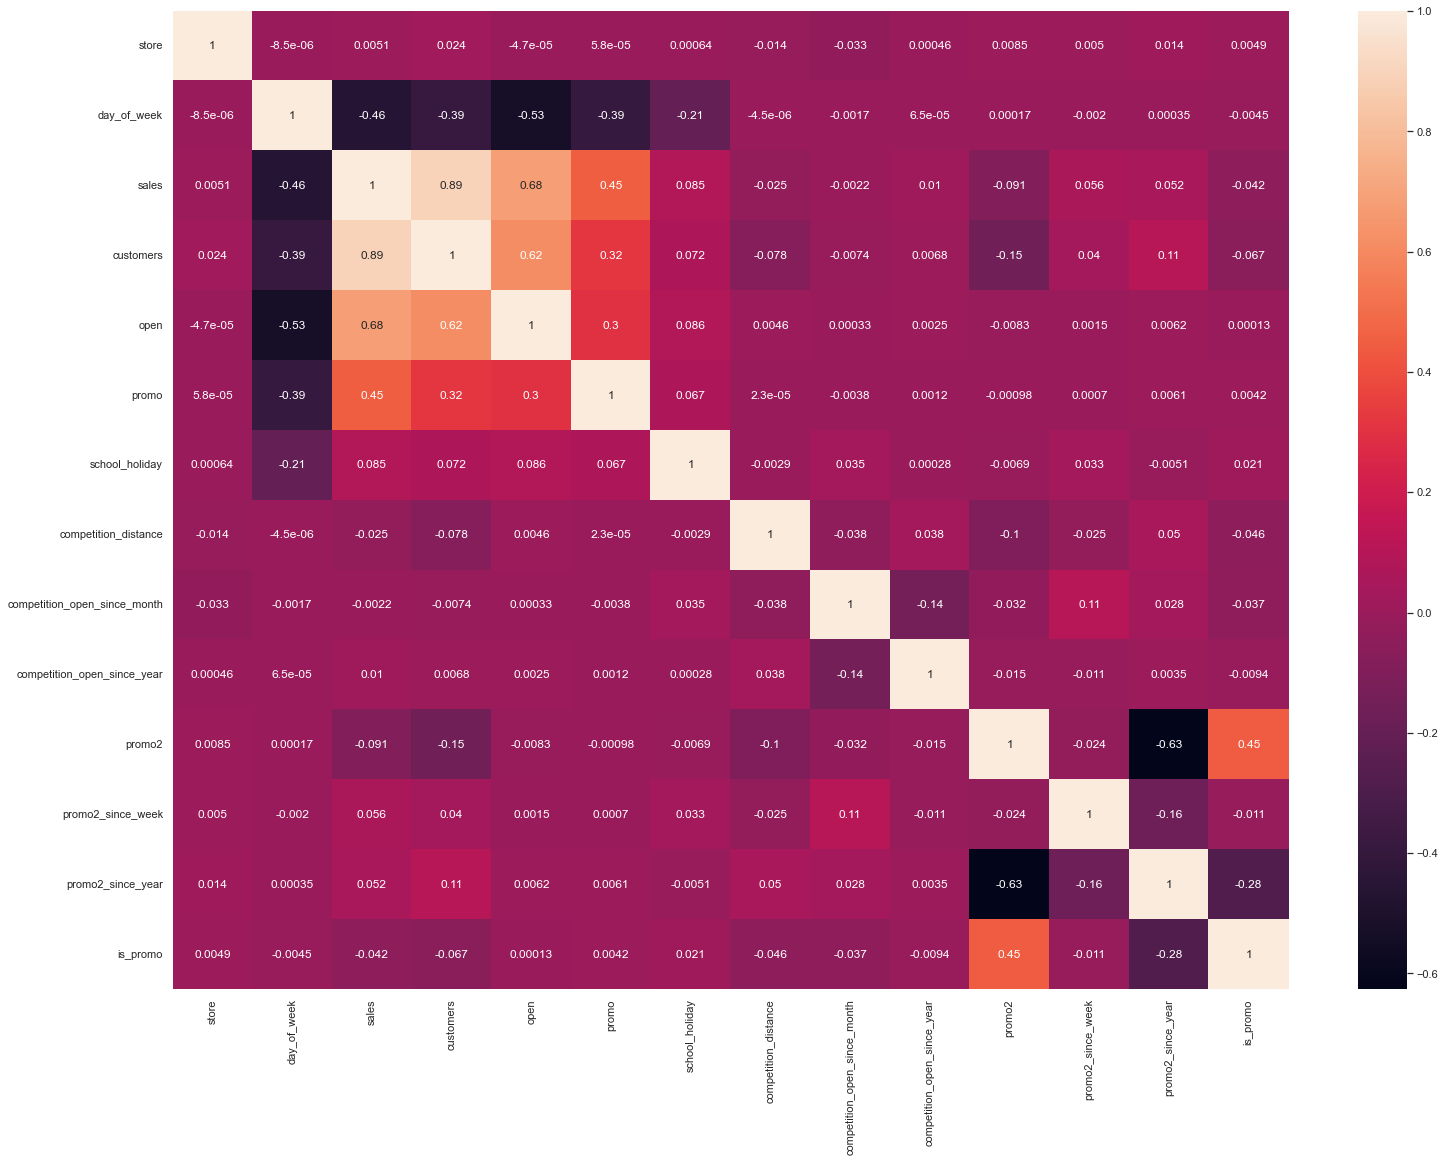

In [49]:
# Correlation between variables
correlation = num_att.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

In [50]:
num_att.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

### 4.3.2 Categorical Attributes

<AxesSubplot:>

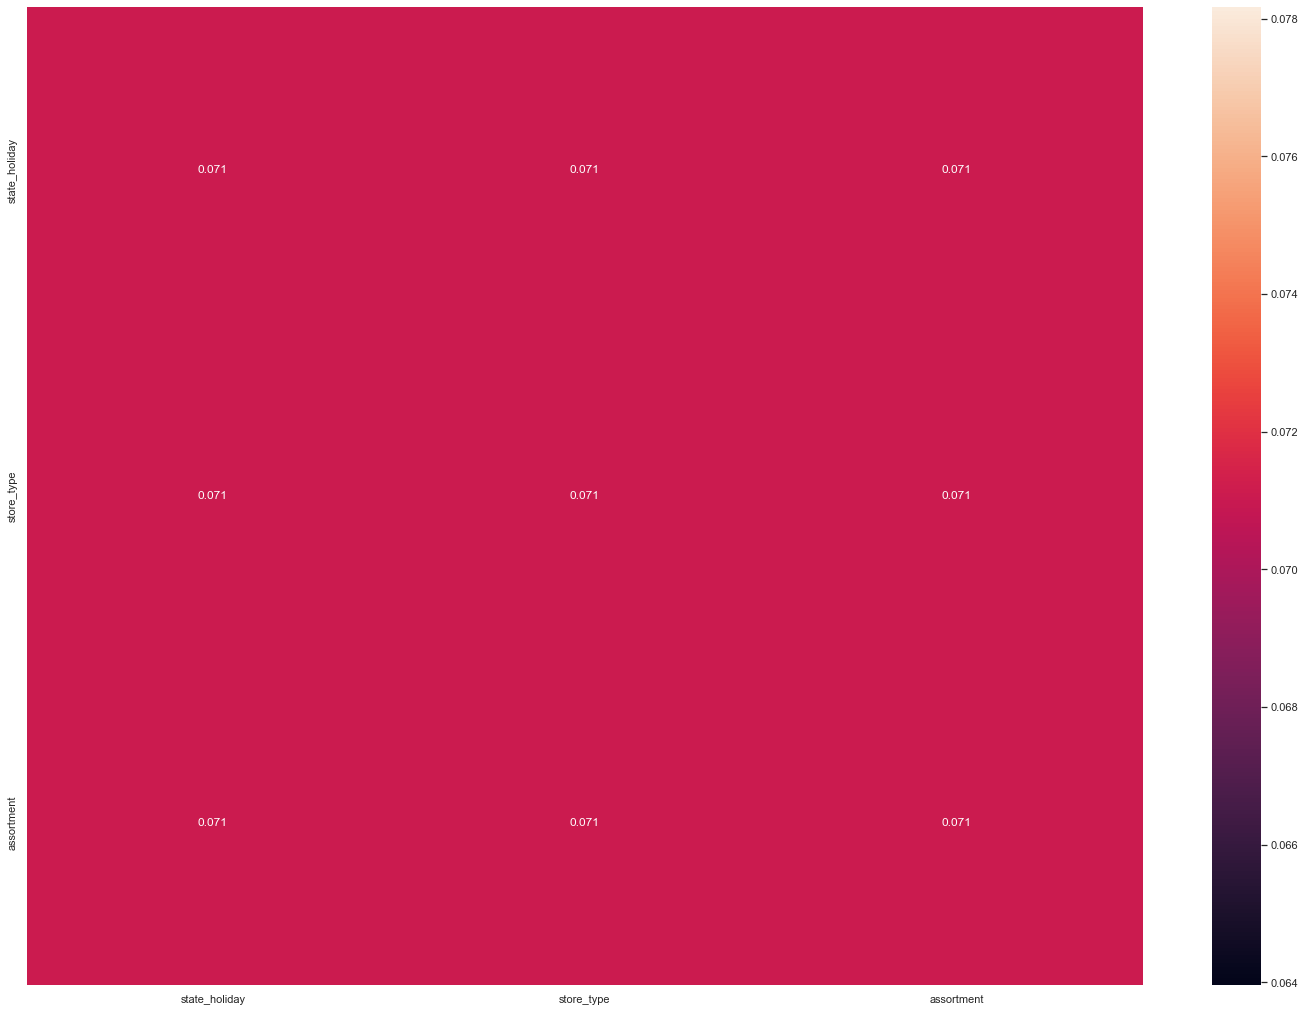

In [51]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

In [52]:
cm = pd.crosstab( a['state_holiday'], a['store_type'] ).to_numpy()

In [53]:
 chi2 = stats.chi2_contingency( cm)[0]

In [54]:
n = cm.sum()

In [55]:
 r, k = cm.shape

In [56]:
v = np.sqrt( (chi2/n)  / ( min( k-1, r-1 ) ) )

In [57]:
a = df4.select_dtypes( include='object' )
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [58]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a' )]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


### Resumo das Hipoteses

# 5.0. STEP 5 - DATA PREPARATION

In [59]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [60]:
a = df5.select_dtypes( include= ['int64', 'float64'] )

In [61]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31


In [62]:
# day of week
# competition_distance


In [63]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] =  rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

#competition time month
df5['competition_time_month'] =  rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] =  mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] =  mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open( 'parameter/year_scaler.pkl', 'wb') )


## 5.3. Transforming

### 5.3.1. Encoding

In [64]:
# state_holiday One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# asssortment Ordinal Encoding
assortment_dict = {'basic': 1,'extra': 2,'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variabe Transformation

In [65]:
df5['sales'] = np.log1p (df5['sales'] )

### 5.3.3. Response Variabe Transformation

In [66]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 7 ) ) )

 
# month
df5['month_sin'] = df5['month'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 30 ) ) )


# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply ( lambda x: np.sin(x * ( 2. * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply ( lambda x: np.cos(x * ( 2. * np.pi / 52 ) ) )



# 6.0. STEP 6 - FEATURE SELECTION

In [67]:
 df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [68]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since' , 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [69]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [70]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [71]:
# training set
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print( " Training Min  Date: {}".format( X_train['date'].min() ) )
print( " Training Max  Date: {}".format( X_train['date'].max() ) )

print( "\nTest Min Date: {}".format( X_test['date'].min() ) )
print( " Test Max Date: {}".format( X_test['date'].max() ) )

 Training Min  Date: 2013-01-01 00:00:00
 Training Max  Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
 Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [72]:
# training and test dataset for boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#Y_train_n = Y_train.values.ravel()

# define RandmomForestRegressor
#rf = RandomForestRegressor ( n_jobs=1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit( X_train_n, Y_train_n )

### 6.2.1. Best Features from Boruta

In [73]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

In [74]:
cols_not_selected_boruta 

NameError: name 'cols_not_selected_boruta' is not defined

In [ ]:
cols_selected_boruta

## 6.3. Manual Feature Selection

In [77]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
  'day_of_week_cos',
  'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

#final features
#cols_selected_boruta.extend( feat_to_add )

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [78]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. STEP 7 - ML MODELLING

In [79]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [80]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [81]:
# model
lr = LinearRegression().fit( x_train, Y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( Y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation


In [82]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

In [83]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/-295.63,0.3 +/-0.02,2952.52 +/-468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [84]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, Y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [85]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/-341.5,0.29 +/-0.01,3057.75 +/-504.26


## 7.4. Random Forest Regressor

In [86]:
# model
rf = RandomForestRegressor (n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, Y_train )

# prediction
yhat_rf = rf.predict(x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( Y_test ), np.expm1( yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Validation

In [87]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/-217.1,0.12 +/-0.02,1254.3 +/-316.17


## 7.5. XGBoost Regressor


In [88]:
# model XGB
model_xgb = xgb.XGBRegressor ( objective='reg:squarederror',
                               n_estimators=100, 
                               eta=0.01,
                               max_depth=10,
                               subsample=0.7,
                               colsample_bytee=0.9).fit( x_train, Y_train )

# prediction
yhat_xgb = model_xgb.predict(x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb) )
xgb_result

[10:25:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 7.5.1. XGBoost Regressor - Cross Validation

In [89]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

[10:25:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:26:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:26:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be use

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.97 +/-587.65,0.95 +/-0.0,7714.03 +/-688.72


## 7.6. Compare Model's performance

### 7.6.1. Single Performance

In [90]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### 7.6.2. Real Performance - Cross Validation

In [91]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/-295.63,0.3 +/-0.02,2952.52 +/-468.37
0,Lasso,2116.38 +/-341.5,0.29 +/-0.01,3057.75 +/-504.26
0,Random Forest Regressor,836.61 +/-217.1,0.12 +/-0.02,1254.3 +/-316.17
0,XGBoost Regressor,7047.97 +/-587.65,0.95 +/-0.0,7714.03 +/-688.72


# 8.0. STEP 8 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [92]:
import random

import warnings
warnings.filterwarnings('ignore');

In [93]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5 ,9 ],
    'subsample': [0.1, 0.5, 0.7 ],
    'colsample_bytee': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [94]:
final_result = pd.DataFrame()

for i in range ( MAX_EVAL ):
    # choose values for parameters randomly
    hp =  { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model 
    model_xgb = xgb.XGBRegressor ( objective='reg:squarederror',
                               n_estimators=hp['n_estimators'], 
                               eta=hp['eta'],
                               max_depth=hp['max_depth'],
                               subsample=hp['subsample'],
                               colsample_bytee=hp['colsample_bytee'],
                               min_child_weight=hp['min_child_weight'] )

    # perfroamnce
    

    # performance
    result =  cross_validation ( x_training, 2, 'XGBoost Regressor', model_xgb,  verbose=False )
    final_result = pd.concat( [final_result, result] )
final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 15}
[10:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'n_estimators': 3000, 'eta': 0.01

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1214.27 +/-55.33,0.16 +/-0.0,1782.6 +/-105.26
0,XGBoost Regressor,1641.51 +/-49.41,0.22 +/-0.0,2392.77 +/-87.25
0,XGBoost Regressor,1807.0 +/-49.81,0.24 +/-0.0,2619.07 +/-87.8
0,XGBoost Regressor,821.97 +/-91.46,0.11 +/-0.01,1187.23 +/-154.74
0,XGBoost Regressor,818.0 +/-90.48,0.11 +/-0.01,1185.24 +/-157.15


## 8.2. Final model

In [95]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 8
        }
#{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 8}

In [96]:
 
    
    # model 
    model_xgb_tuned = xgb.XGBRegressor ( objective='reg:squarederror',
                                       n_estimators=param_tuned['n_estimators'], 
                                       eta=param_tuned['eta'],
                                       max_depth=param_tuned['max_depth'],
                                       subsample=param_tuned['subsample'],
                                       colsample_bytee=param_tuned['colsample_bytee'],
                                       min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, Y_train)

    # prediciton
    yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
    

    # performance
    xgb_result_tuned = result =  ml_error( 'XGBoost REgressor', np.expm1 ( Y_test ), np.expm1( yhat_xgb_tuned ) )
    xgb_result_tuned 

[11:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost REgressor,669.79917,0.097435,981.306113


In [97]:
mpe = mean_percentage_error( np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.00017970285012787183

In [98]:
import pickle 

In [99]:
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pkl', 'wb'))

# 9. STEP 9 - TRANSLATION AND INTERPRETATION OF ERROR

In [100]:
df9 = X_test [ cols_selected_boruta_full ]

# rescale

df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [101]:
# sum of predicitons
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] )).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )
df92.head()

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario','best_scenario', 'MAE', 'MAPE']]

,store,predictions,MAE,MAPE
0,1,162183.109375,292.722135,0.065986
1,2,179236.109375,353.721601,0.073013
2,3,261104.687500,559.406369,0.079174
3,4,341583.531250,874.206965,0.082995
4,5,175636.343750,444.689800,0.100409


<AxesSubplot:xlabel='store', ylabel='MAPE'>

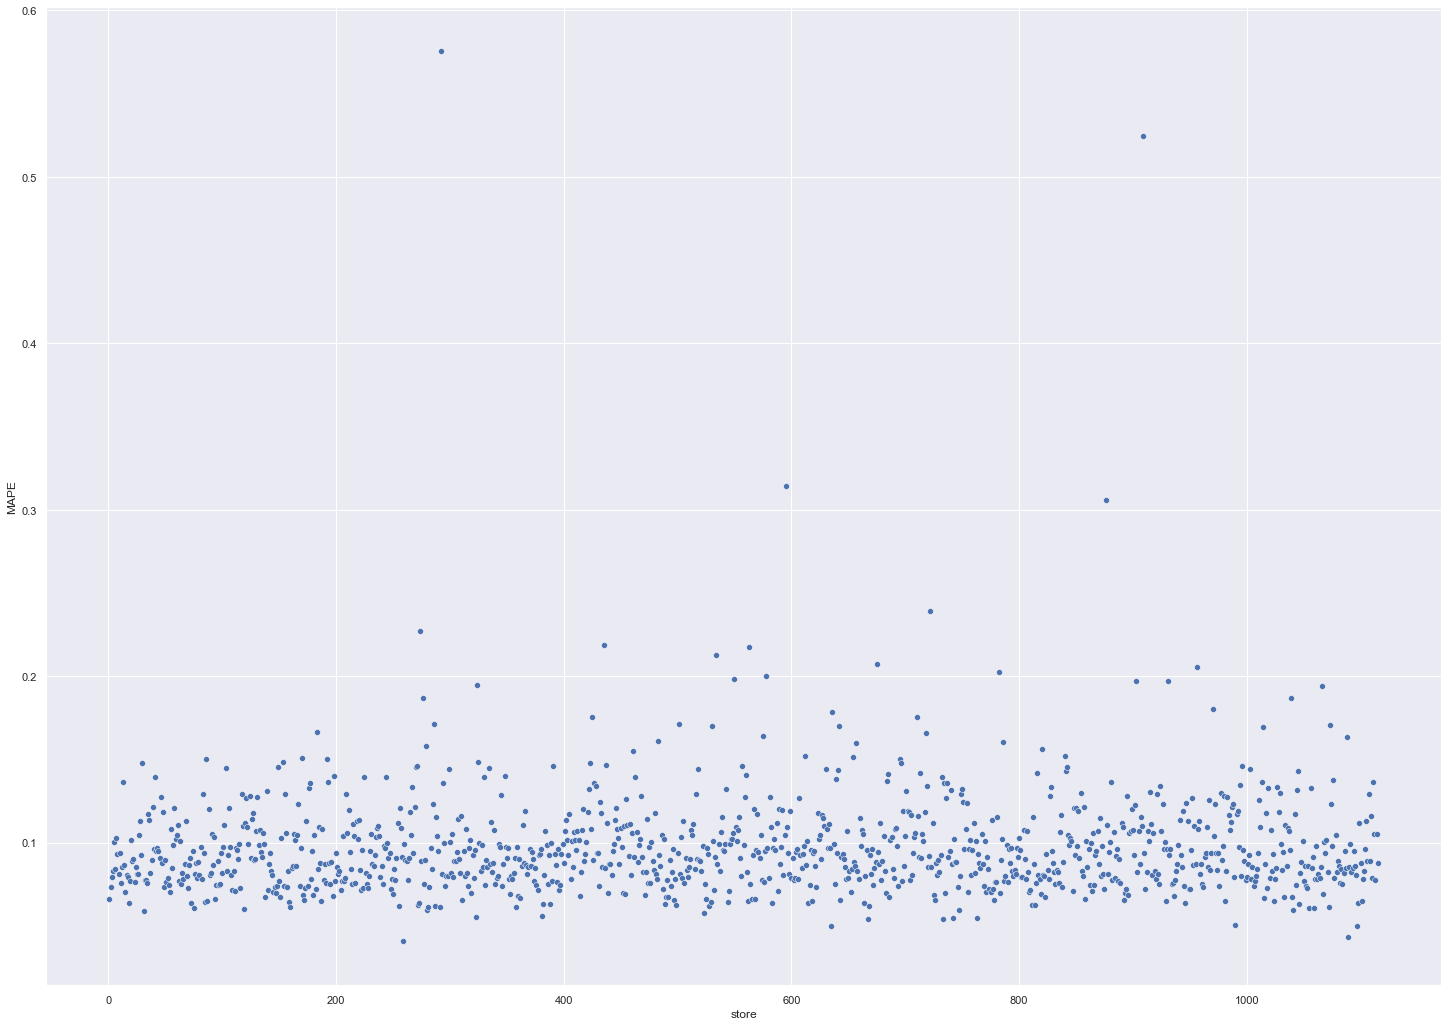

In [102]:
sns.scatterplot(x='store', y='MAPE',data=df92 )

In [103]:
df92.sort_values( 'MAPE', ascending=False).tail()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
989,990,238594.921875,238280.880463,238908.963287,314.041412,0.050694
634,635,213501.156250,213202.146550,213800.165950,299.009700,0.049944
1096,1097,445362.437500,444810.070188,445914.804812,552.367312,0.049938
1088,1089,381056.750000,380588.991000,381524.509000,467.759000,0.043488
258,259,532967.312500,532423.508108,533511.116892,543.804392,0.040975


In [104]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
722,723,278631.375000,277883.802536,279378.947464,747.572464,0.085088
596,597,194291.890625,193823.534140,194760.247110,468.356485,0.093450
323,324,201843.343750,201080.251524,202606.435976,763.092226,0.194503
474,475,233488.281250,232894.573744,234081.988756,593.707506,0.097151
111,112,224277.781250,223644.846376,224910.716124,632.934874,0.096917


## 9.2. Total Performance

In [105]:
df93 = df92[['predictions', 'worst_scenario','best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,363,264.00"
1,worst_scenario,"R$282,612,719.65"
2,best_scenario,"R$284,113,825.26"


## 9.3. Machine Learning Performance

In [106]:
df9['error']  = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:>

<AxesSubplot:xlabel='date', ylabel='sales'>

<AxesSubplot:xlabel='date', ylabel='sales'>

<AxesSubplot:>

<AxesSubplot:xlabel='date', ylabel='error_rate'>

<AxesSubplot:>

<AxesSubplot:xlabel='error', ylabel='Density'>

<AxesSubplot:>

<AxesSubplot:xlabel='predictions', ylabel='error'>

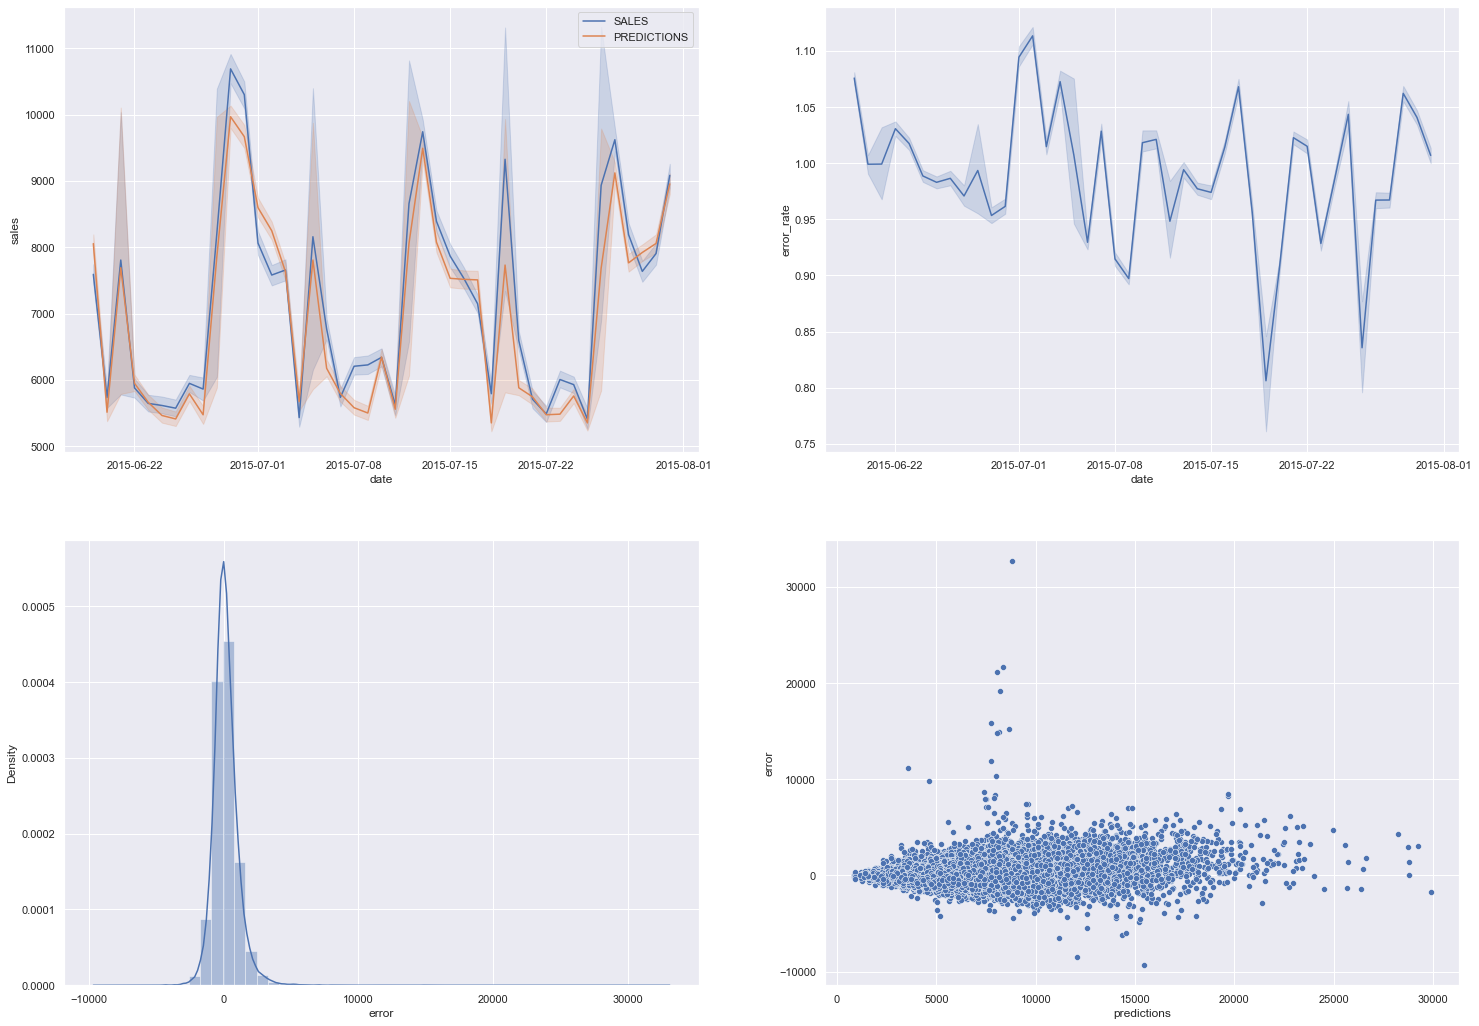

In [107]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )

plt.subplot( 2, 2, 3 )
sns.distplot(df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(df9['predictions'], df9['error'] )

# 10. STEP 10 - DEPLOY MODEL TO PRODUCTION

In [40]:
import requests

In [12]:
# Saved Trained Model
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

NameError: name 'model_xgb_tuned' is not defined

## 10.1. Rossmann Class

In [4]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path=''
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '\parameter\\competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\parameter\\competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '\parameter\\promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + '\parameter\\year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + '\parameter\\store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [7]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( r'C:/Users/m/Desktop/repos/Sales-Prediction-Pharmacy/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )


@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [51]:
# loading test dataset
df10 = pd.read_csv( 'data/test.csv' )

In [52]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [29, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [53]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [57]:
# API Call
#url = 'http://192.168.15.186:5000/rossmann/predict'
url = 'https://rossmann-model-ds.herokuapp.com//rossmann/predict' 
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [58]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [59]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 22 will sell R$168,173.22 in the next 6 weeks
Store Number 23 will sell R$227,852.85 in the next 6 weeks
Store Number 29 will sell R$286,500.26 in the next 6 weeks


In [16]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,20,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,7431.163574
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6625.878418
2,23,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4060.0,8,2005,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,5573.726074
3,20,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,7322.521973
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6694.115723


In [20]:
data 


'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 23, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 4060.0, "CompetitionOpenSinceMonth": 8.0, "CompetitionOpenSinceYear": 2005.0, "Promo2": 0, "Promo2SinceWeek